# FOF temporal analysis serology

# Importing modules 

In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm, colors
import contextily as ctx
from spatial_tools import fof, clustering
from stat_tools import estimations
from pregmal_pytools import spatial_utils
from epifriends import epifriends
from time import time

# Importing data 

In [2]:
#Importing data
mipmon, cross, cross210, antigens = spatial_utils.import_spatial_data()
mipmon['year'] = pd.to_datetime(mipmon['visdate']).dt.year
mipmon['date'] = mipmon['visdate']

/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/pregmal_pytools-1.0-py3.8.egg/pregmal_pytools/spatial_utils.py:290: Se

## Defining masks and other definitions 

In [3]:
#MiPMon masks
has_geo_mip = mipmon['latitude'].notnull()&mipmon['longitude'].notnull()
has_pcr_mip = mipmon['pcrpos'].notnull()&has_geo_mip
mip_pcrpos = mipmon['pcrpos'] == 1
mip_pcrneg = mipmon['pcrpos'] == 0
mip_rdtpos = mipmon['density'] >= 100
mip_rdtneg = mipmon['density'] < 100
prenatal = (mipmon['visit'] == 'PN')&has_pcr_mip

#Define masks for MiPMon data
mipmon_pn = prenatal&has_geo_mip
mipmon_pg = mipmon_pn&(mipmon['gestnum'] == 1)
mipmon_sg = mipmon_pn&(mipmon['gestnum'] == 2)
mipmon_12g = mipmon_pn&(mipmon['gestnum'] <= 2)
mipmon_mg = mipmon_pn&(mipmon['gestnum'] > 1)
mipmon_3g = mipmon_pn&(mipmon['gestnum'] > 2)
mipmon_hiv_pos = mipmon_pn&(mipmon['hiv'] == 'HIV+')
mipmon_hiv_neg = mipmon_pn&(mipmon['hiv'] == 'HIV-')
mipmon_pg_hiv_pos = mipmon_pg&mipmon_hiv_pos
mipmon_pg_hiv_neg = mipmon_pg&mipmon_hiv_neg

mipmon_selection = {
    'All prenatal' : mipmon_pn,
    'Primigravid' : mipmon_pg,
    #'Secundigravid' : mipmon_sg,
    #'1-2gravid' : mipmon_12g,
    #'>2gravid' : mipmon_3g,
    'Multigravid' : mipmon_mg,
    'HIV+' : mipmon_hiv_pos,
    'HIV-' : mipmon_hiv_neg,
    #'PG HIV+' : mipmon_pg_hiv_pos,
    #'Primigravid HIV-' : mipmon_pg_hiv_neg,
}


#Defining x and y coordinates
geo_mask = (mipmon['latitude'].notnull())&(mipmon['longitude'].notnull())
mipmon['x'] = mipmon['geometry'][geo_mask].apply(lambda p: p.x)
mipmon['y'] = mipmon['geometry'][geo_mask].apply(lambda p: p.y)

#Define names and positions of main locations
list_locs = {
    'Manhica' : [32.80722050, -25.40221980], #From Pau Cisteró excel
    'Maputo' : [32.576388888888889, -25.915277666666],
    #'Montepuez' : [38.99972150, -13.12555980], #From Pau Cisteró excel
    'Chokwe' : [33.005166666666666667, -24.5252777777777777],
    #'Moatize' : [33.73333040, -16.11666620], #From Pau Cisteró excel
    #'Dondo' : [34.75, -19.6166666666666667],
    'Magude' : [32.64216410, -25.02049992], #From Pau Cisteró excel
    'Ilha Josina' : [32.92210000, -25.09330000], #From Pau Cisteró excel
    'Xinavane' : [32.791885, -25.048534],
    'Panjane' : [32.352430, -24.899469],
    'Motaze' : [32.860569, -24.810357],
    'Mapulanguene' : [32.081602, -24.491015],
    'Taninga' : [32.825796, -25.182094],
    'Palmeira' : [32.869766, -25.261457],
    #'Massinga' : [35.37405260,-23.32666250], #From Pau Cisteró excel
    #'Mopeia' : [35.71338490, -17.97391000], #From Pau Cisteró excel
    }

locations = pd.DataFrame({'location' : [i for i in list_locs], 'longitude': [list_locs[i][0] for i in list_locs], 'latitude': [list_locs[i][1] for i in list_locs]})
locations = geopandas.GeoDataFrame(locations, geometry = geopandas.points_from_xy(locations['longitude'], locations['latitude']))
locations = locations.set_crs(epsg=4326)
locations = locations.to_crs(epsg=3857)

years = [2017, 2018, 2019]

## Running temporal analysis 

In [4]:
output_path = '/home/isglobal.lan/apujol/isglobal/projects/pregmal/notebooks/output/fof/mipmon/serology/'

# Running temporal analysis for all antigens

In [5]:
def find_timesteps_with_id(epi_list, tempid):
    timesteps = []
    for i in range(len(epi_list)):
        if tempid in epi_list[i]['tempID'].unique():
            timesteps.append(i)
    return timesteps

-------Running analysis for MSP1------


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

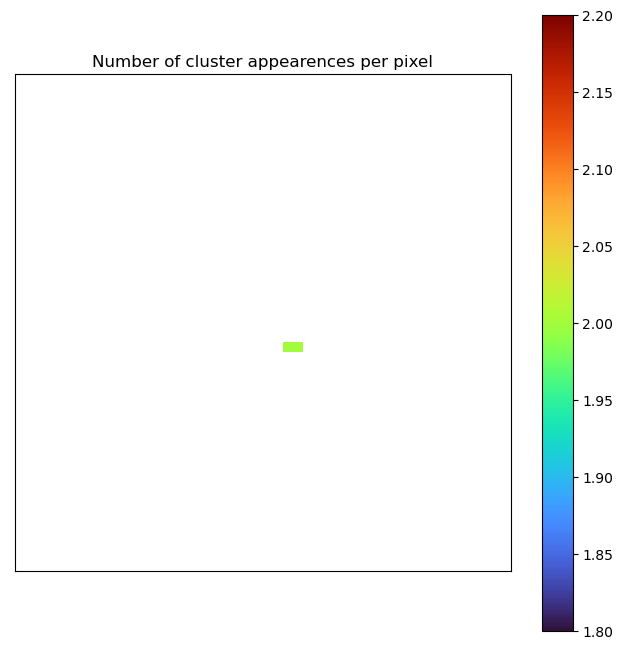

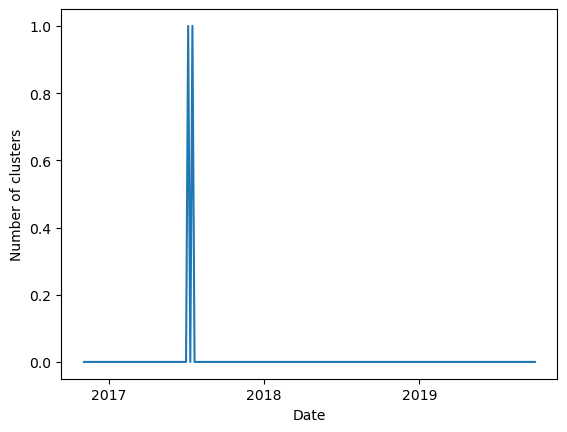

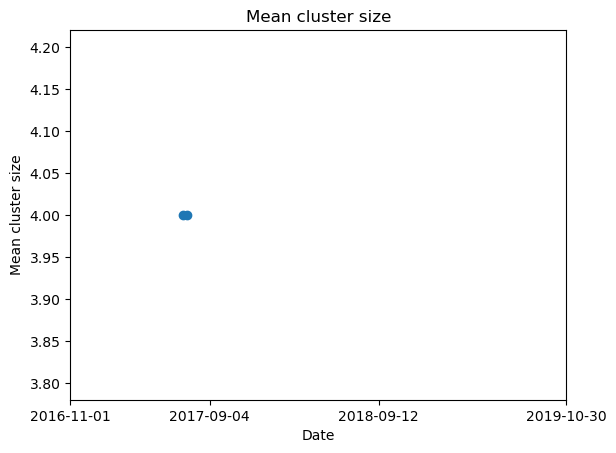

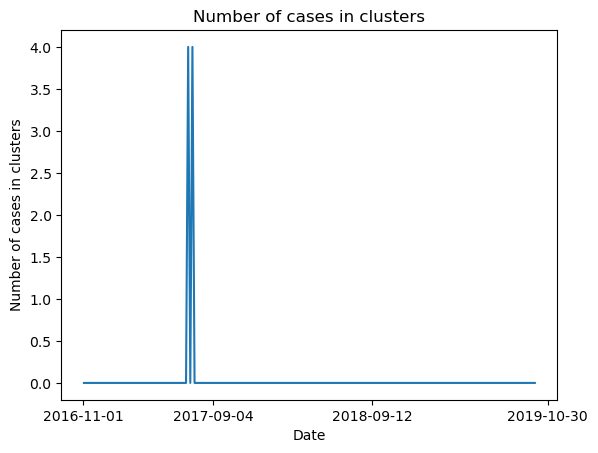

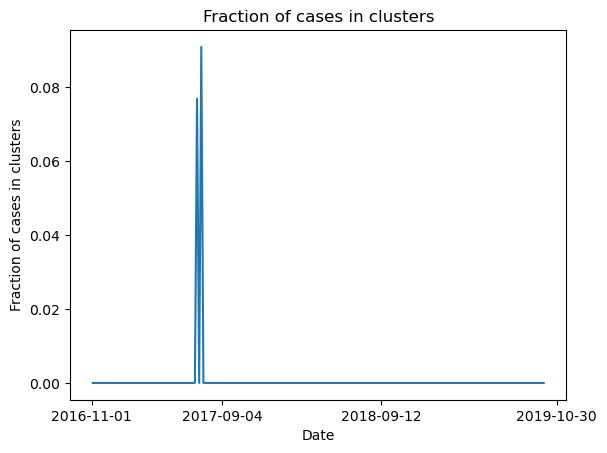

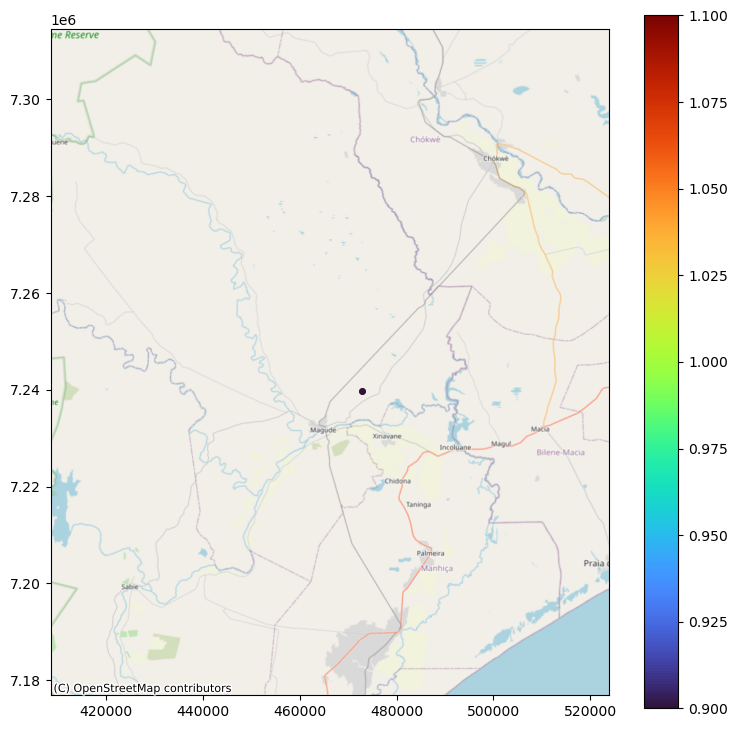

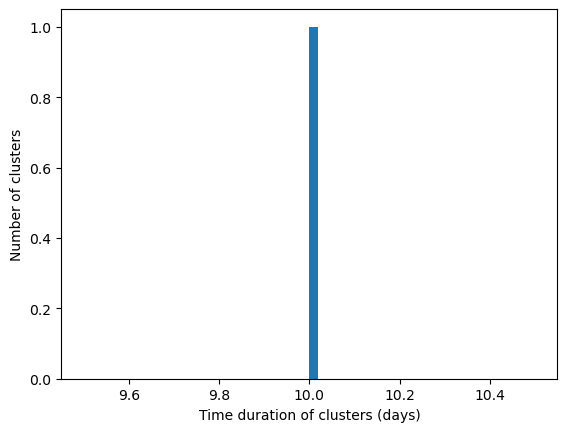

[10]
Maximum limelife: 10


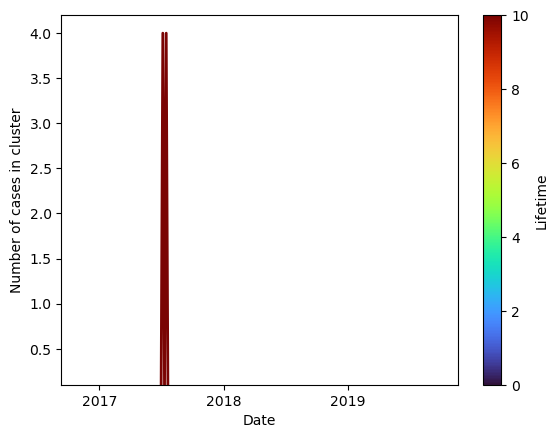

-------Running analysis for HSP40------


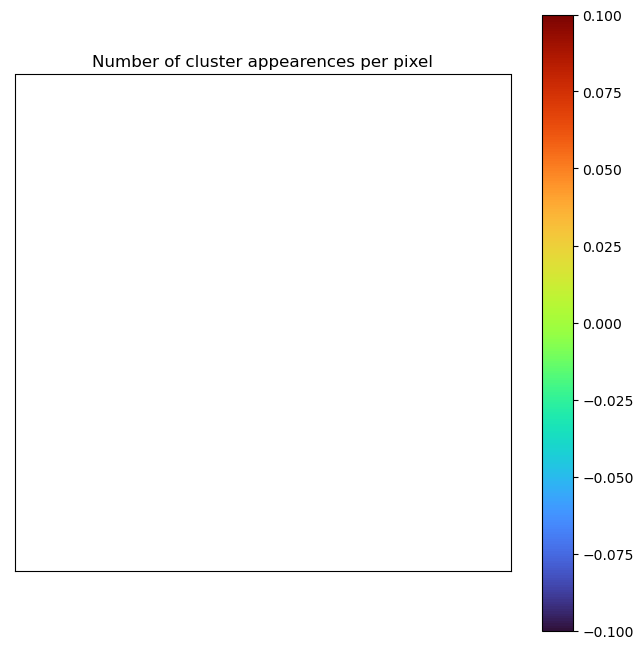

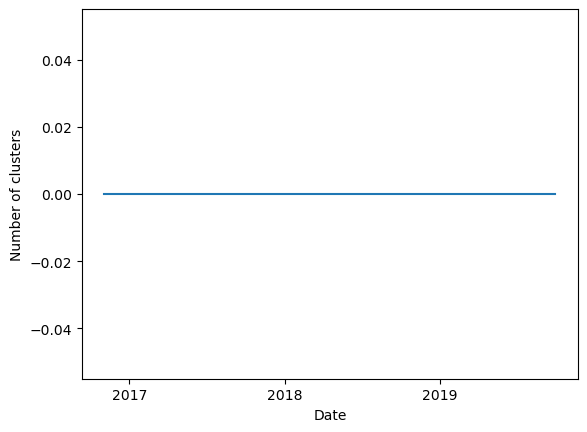

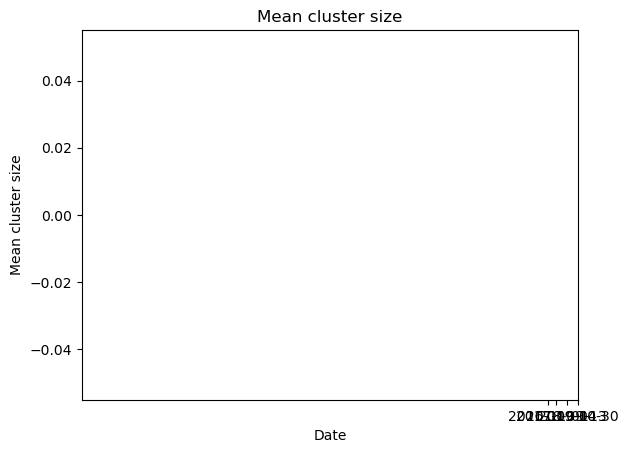

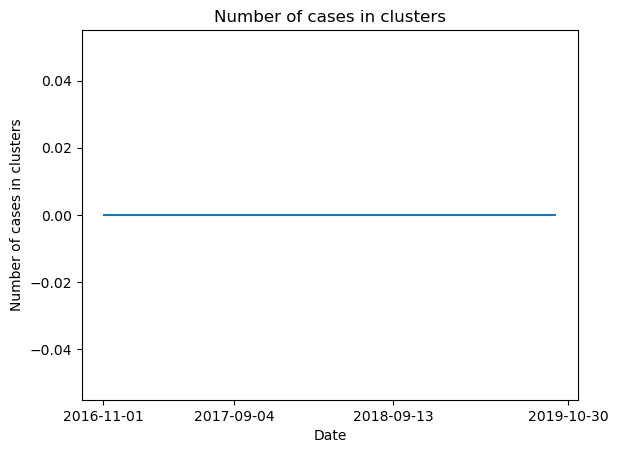

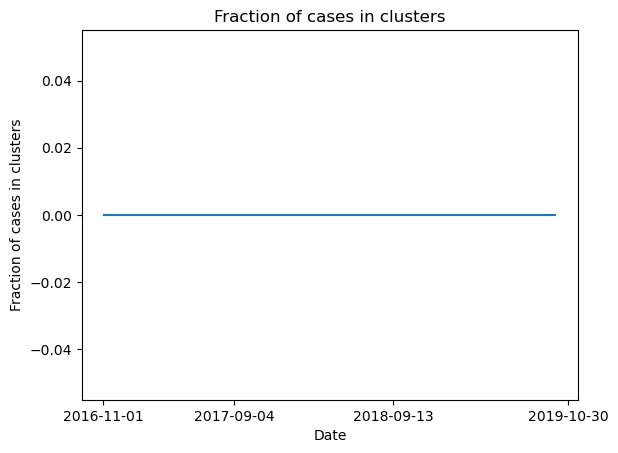

-------Running analysis for Etramp------


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

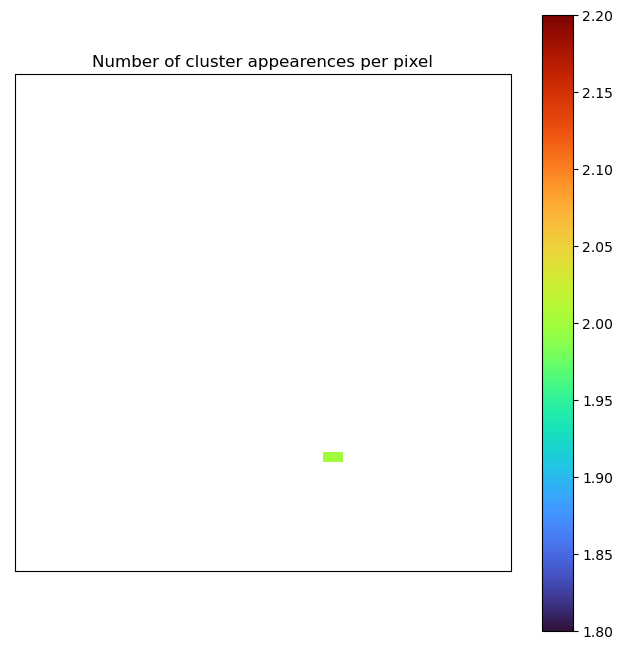

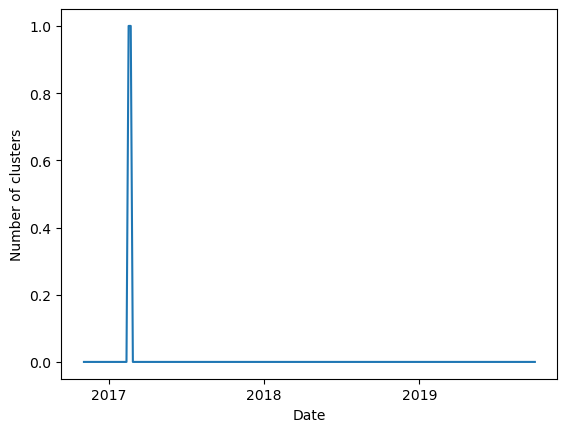

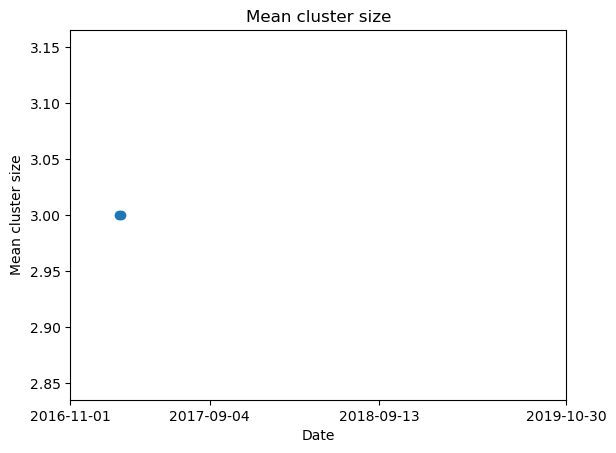

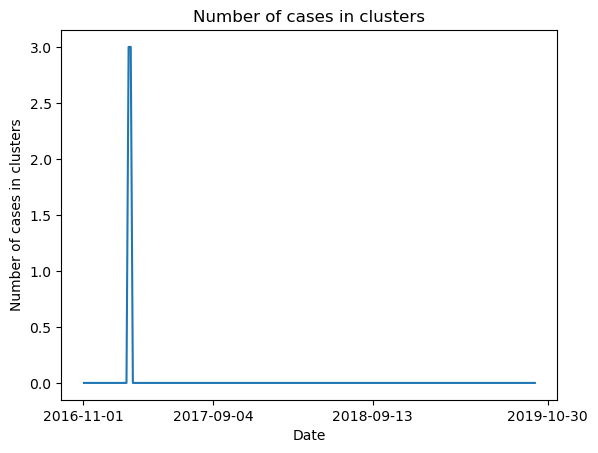

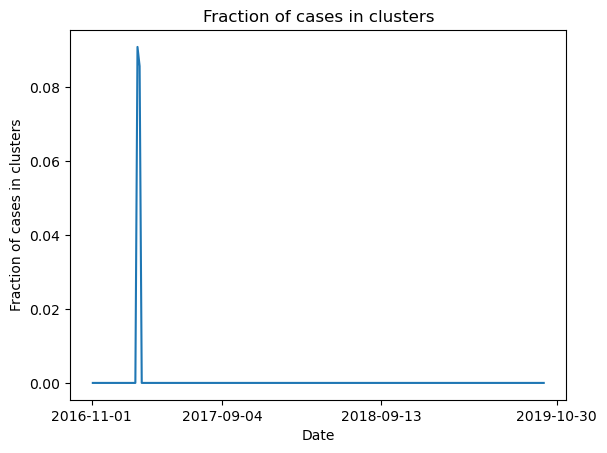

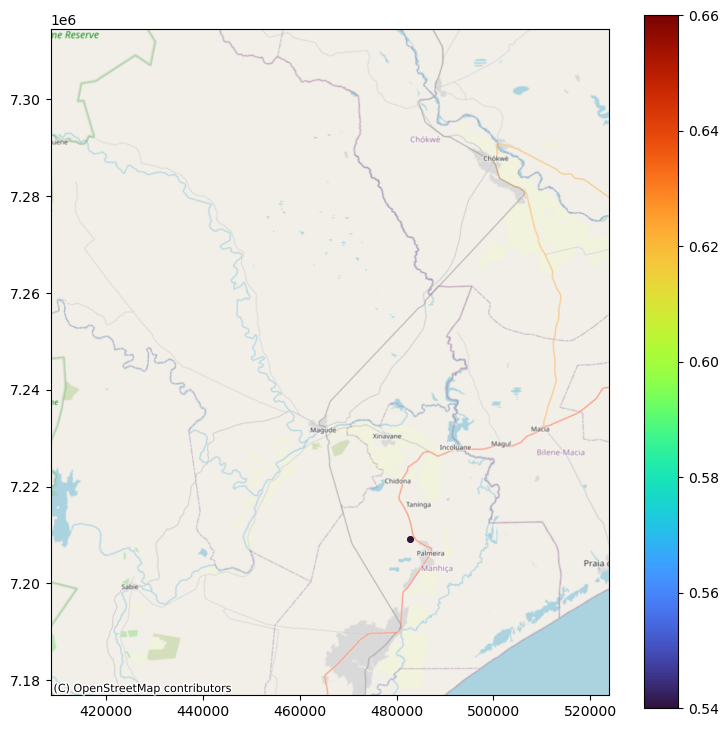

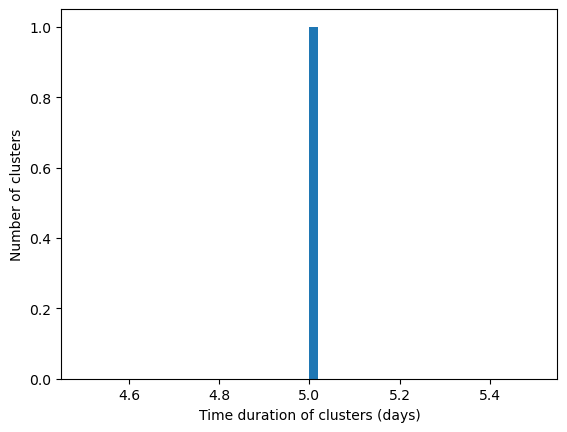

[5]
Maximum limelife: 5


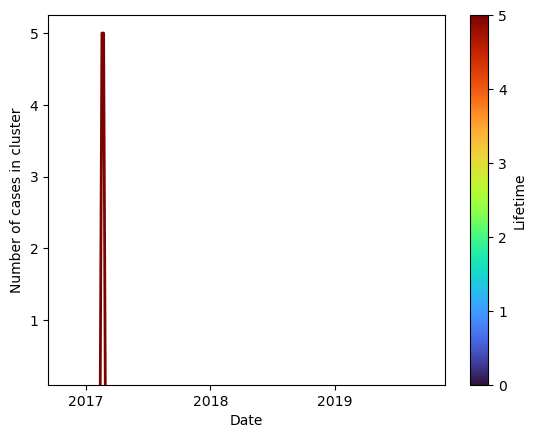

-------Running analysis for ACS5------


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

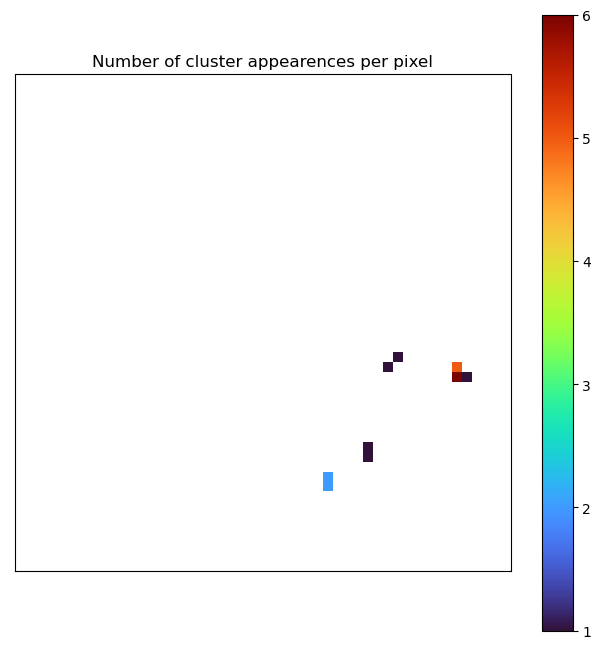

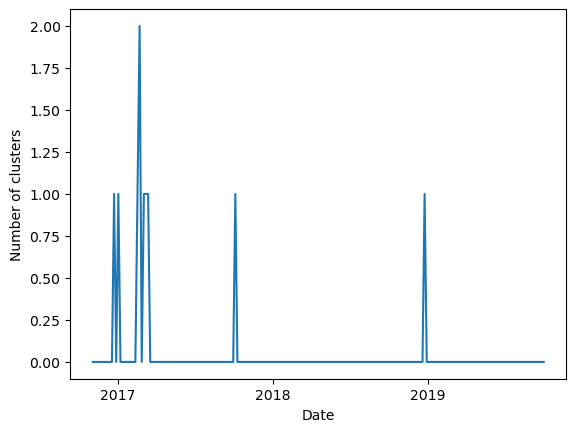

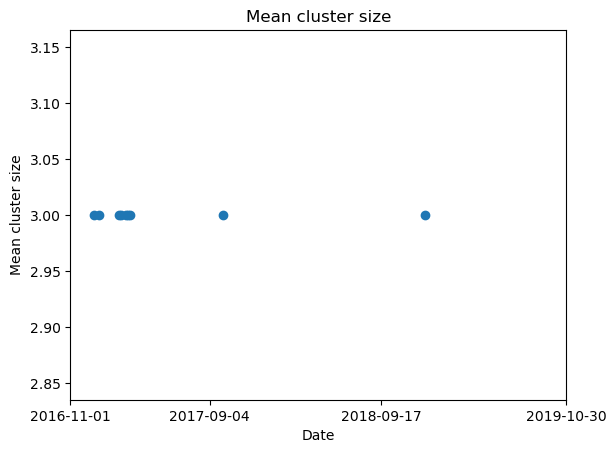

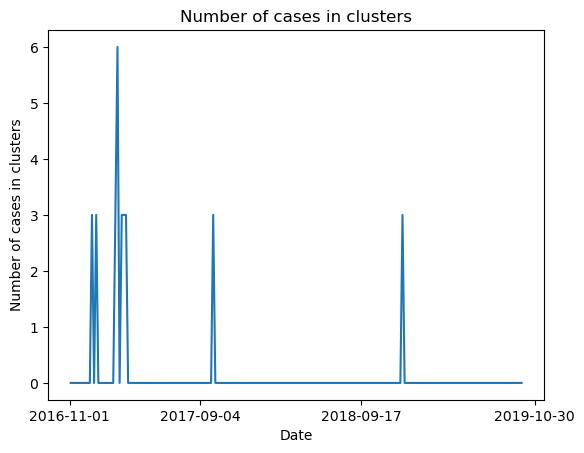

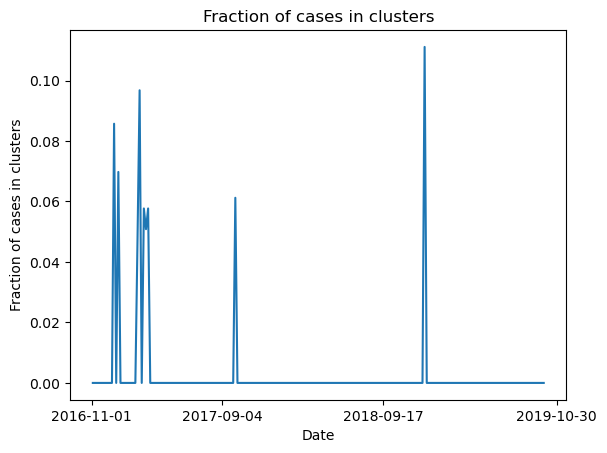

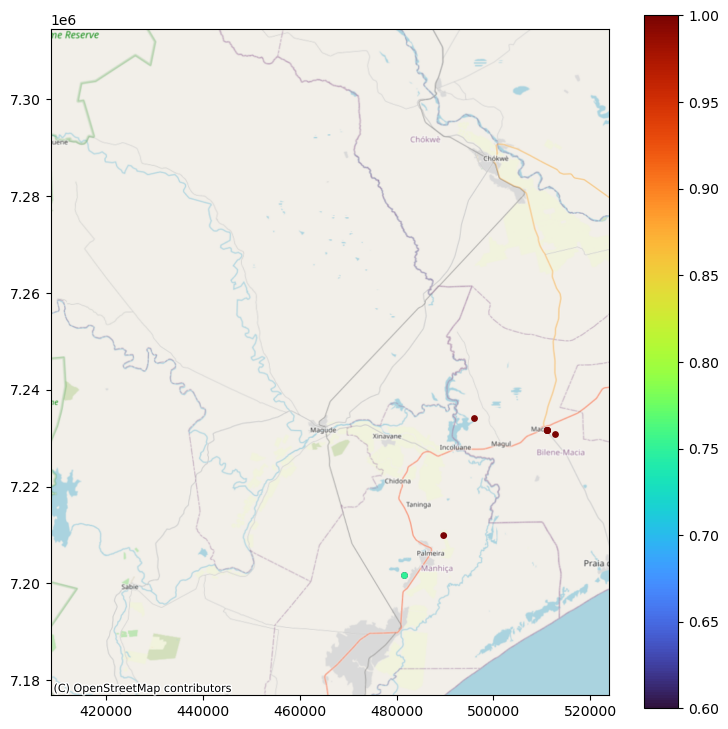

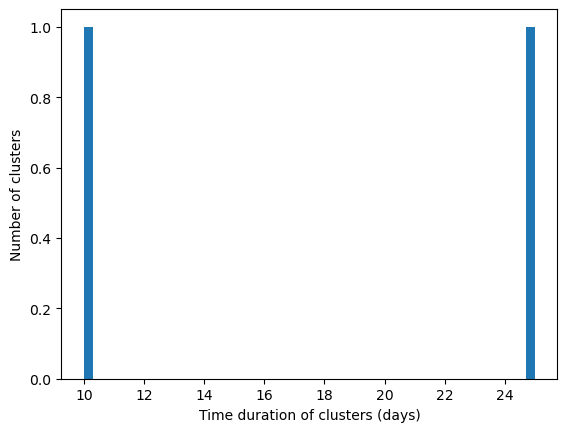

[ 0 10 25]
Maximum limelife: 25


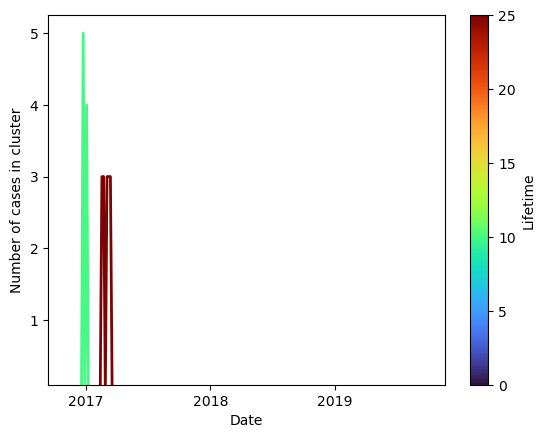

-------Running analysis for EBA175------


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

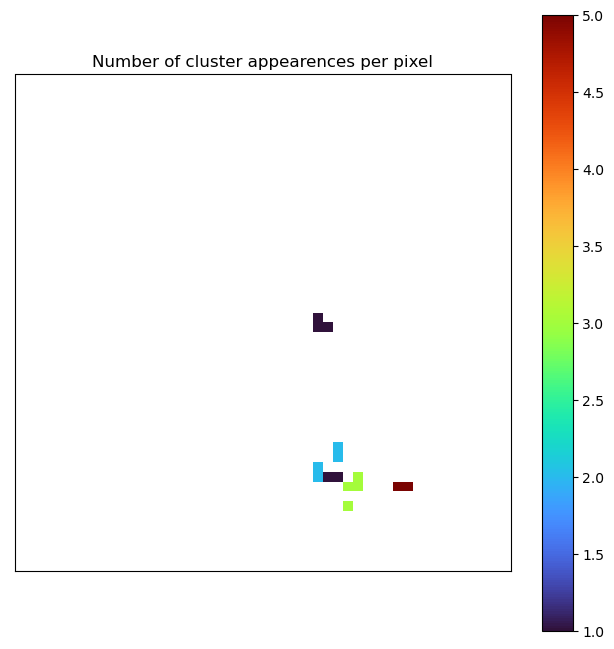

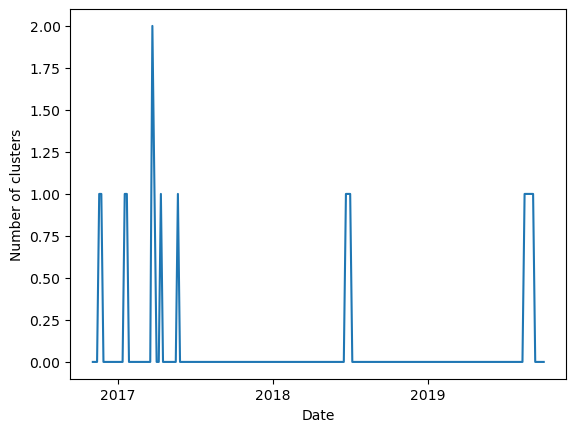

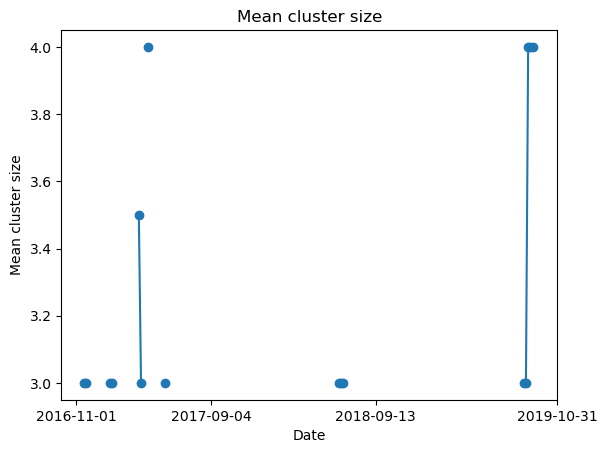

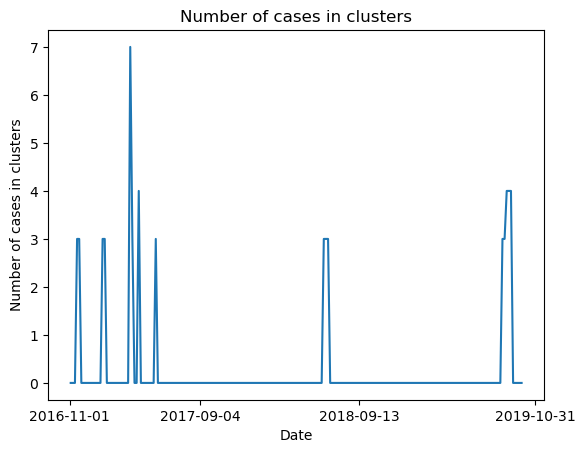

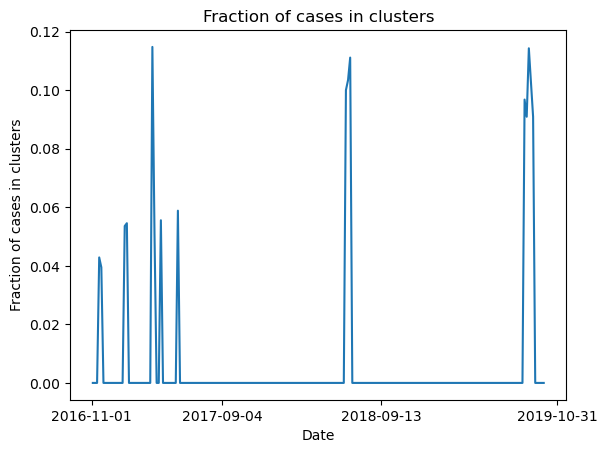

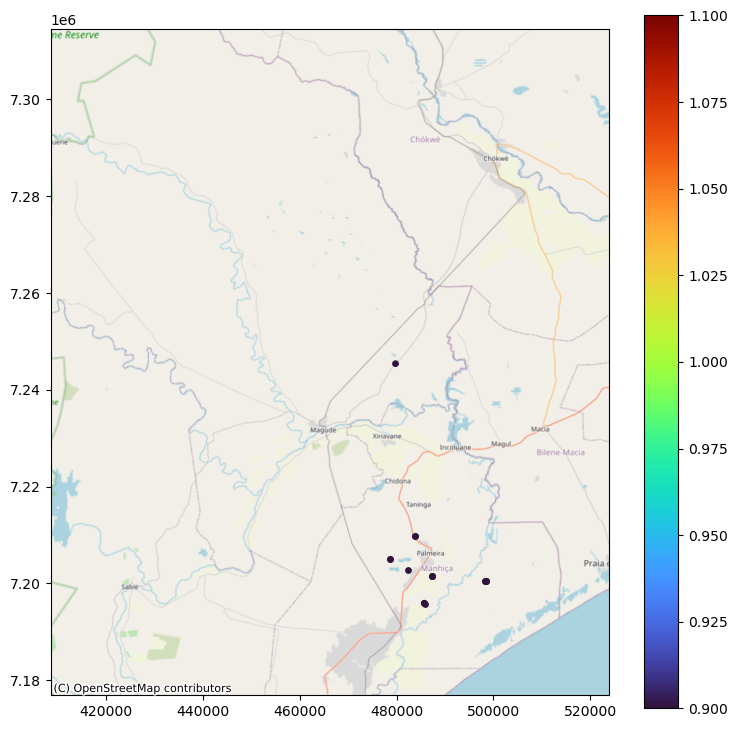

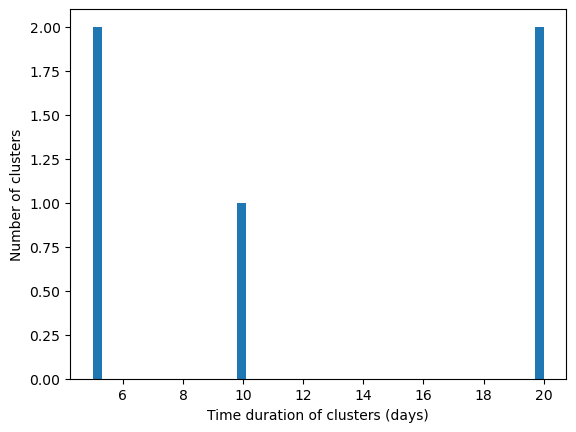

[ 0  5 10 20]
Maximum limelife: 20


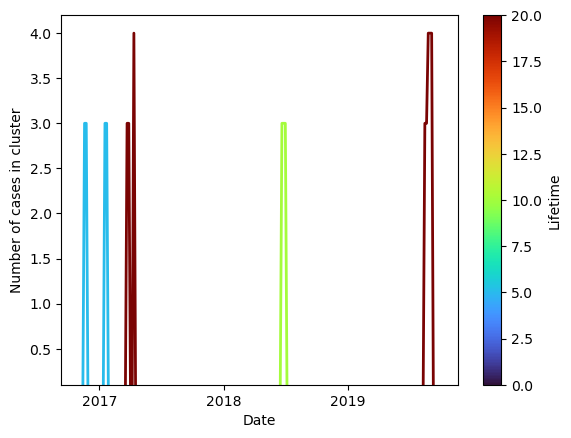

-------Running analysis for PfTramp------


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

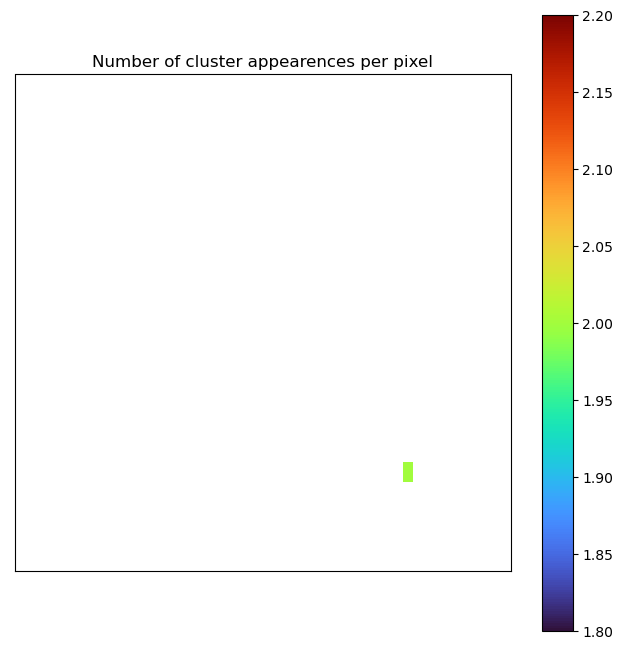

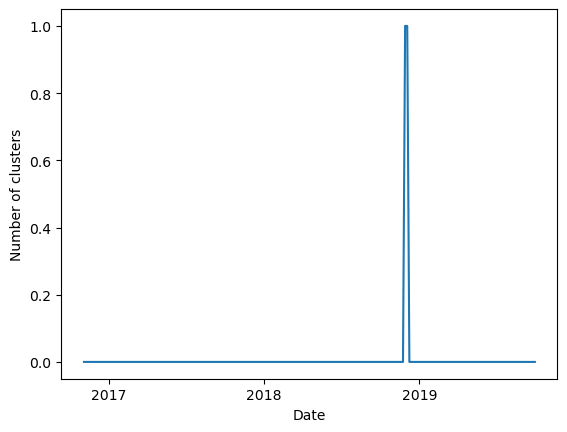

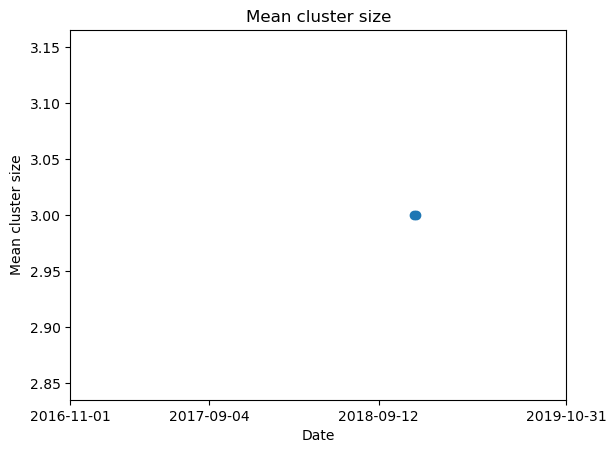

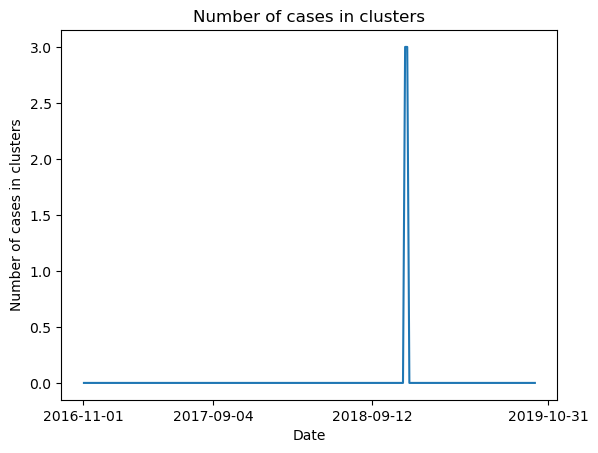

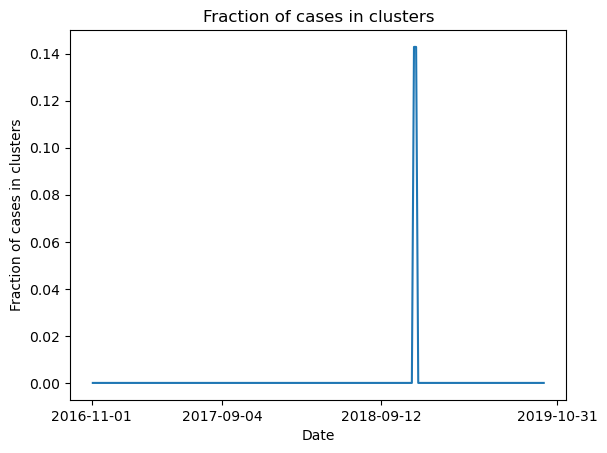

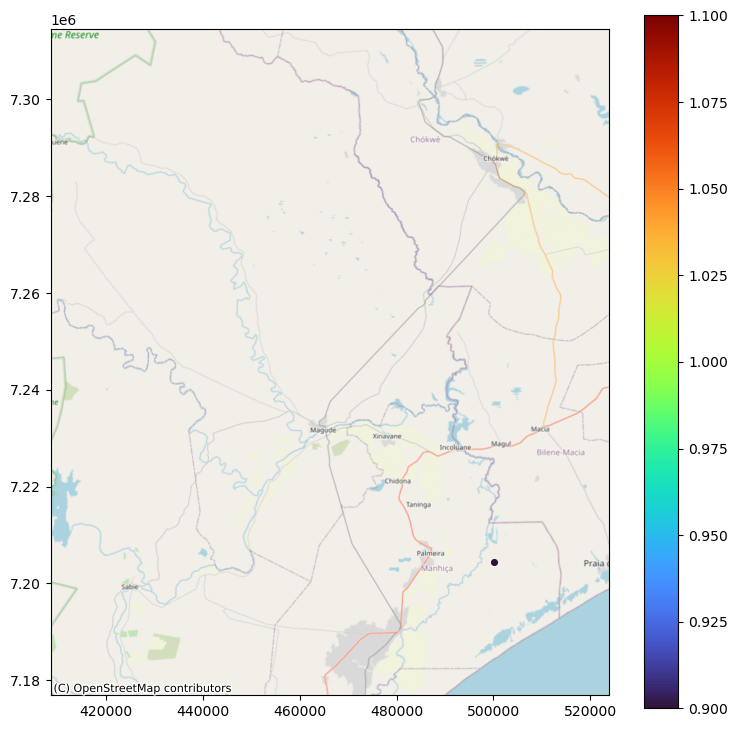

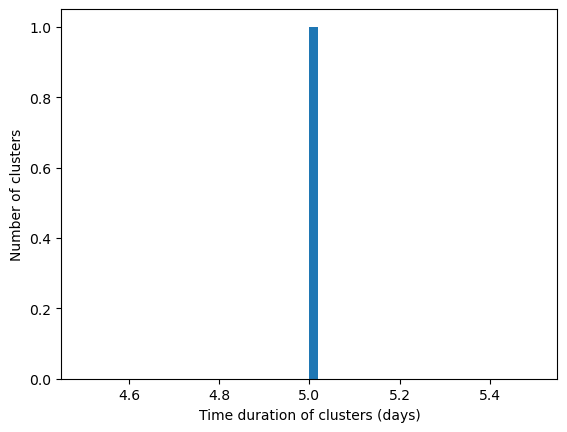

[5]
Maximum limelife: 5


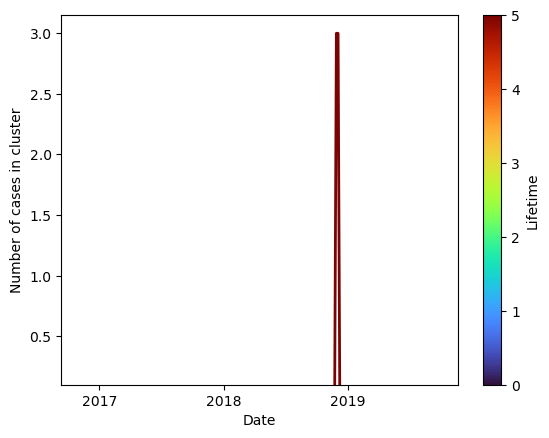

-------Running analysis for GEXP18------


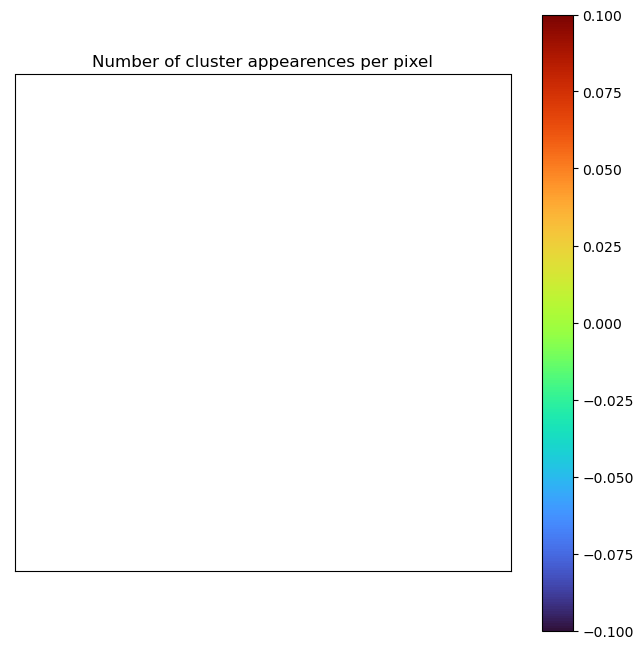

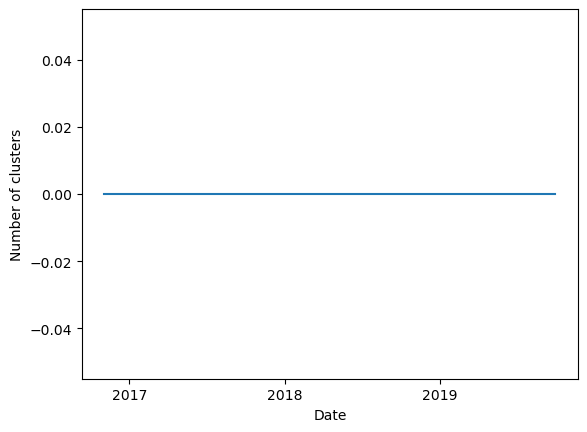

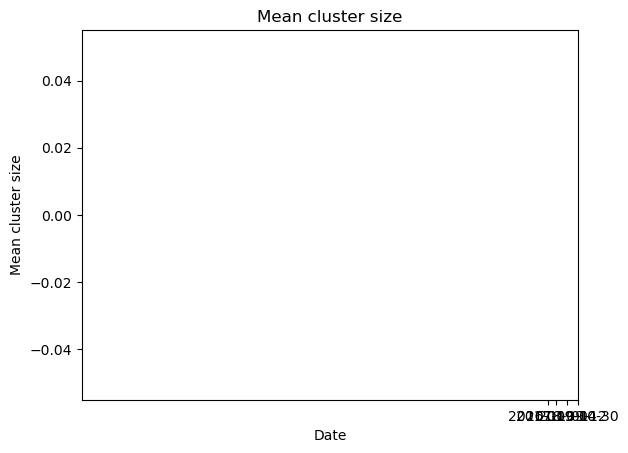

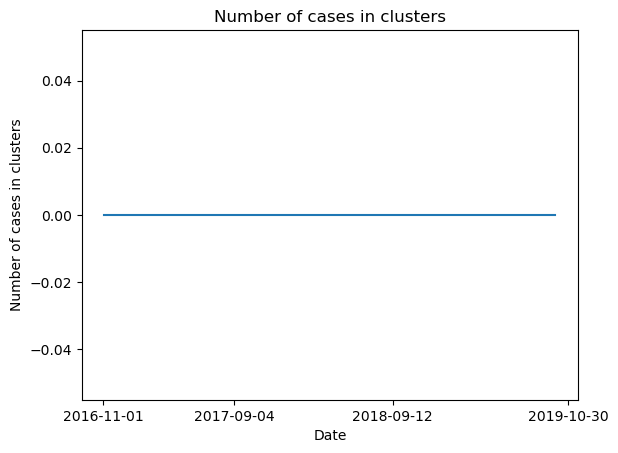

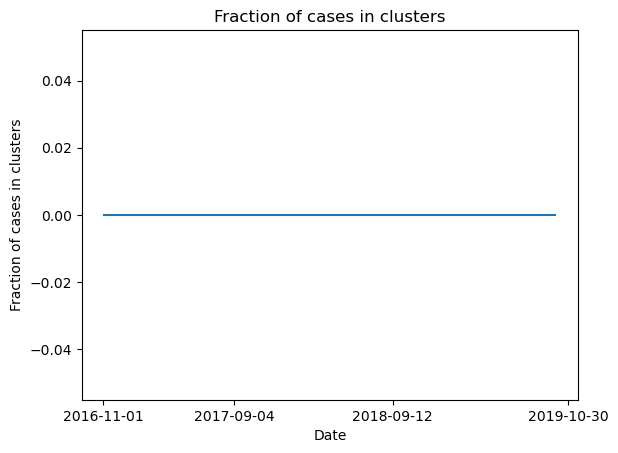

-------Running analysis for PfRH2------


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

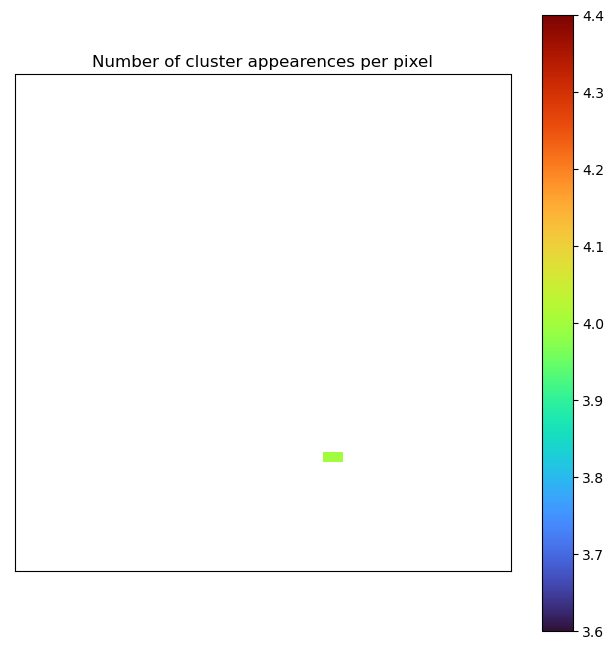

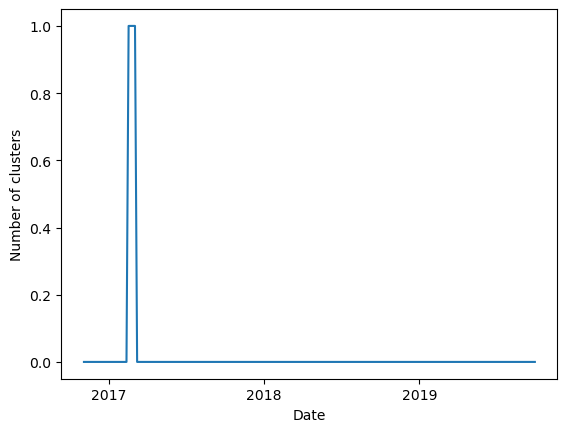

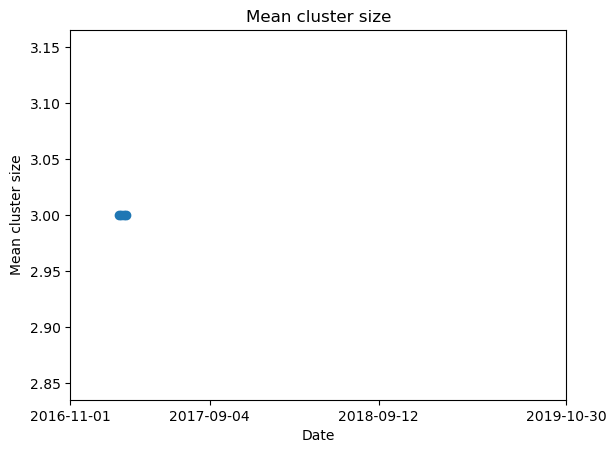

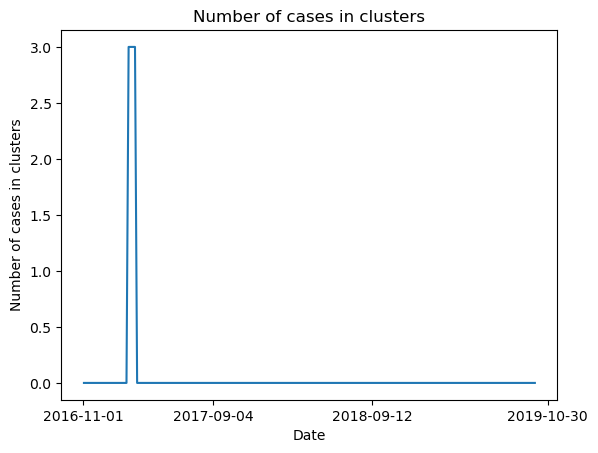

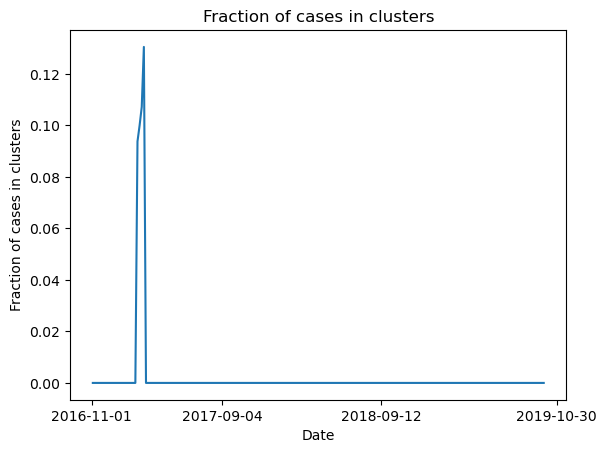

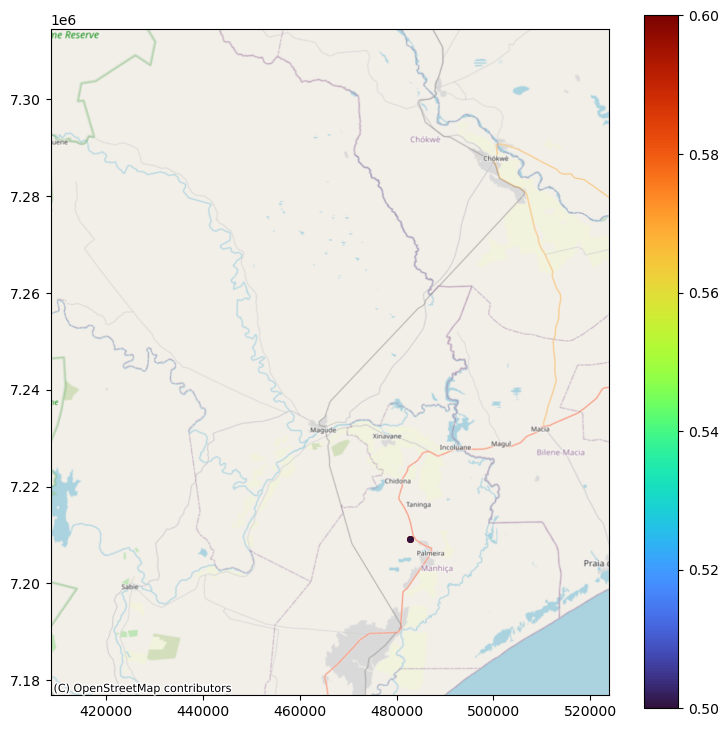

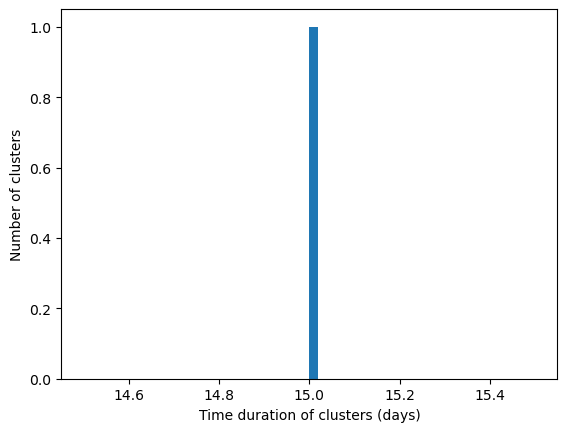

[15]
Maximum limelife: 15


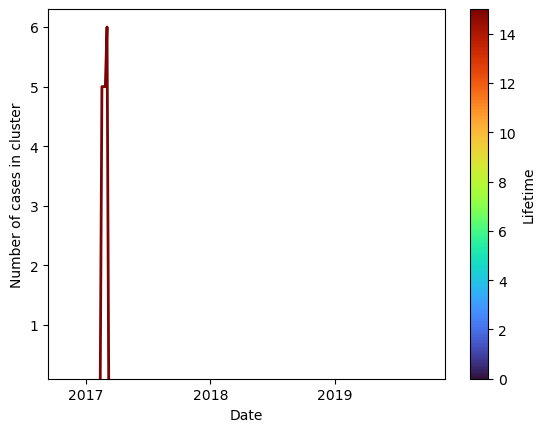

-------Running analysis for PfRH5------


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

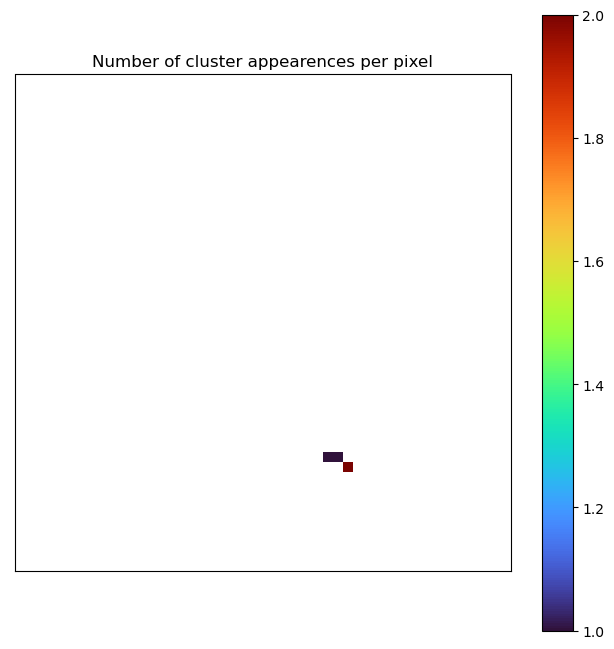

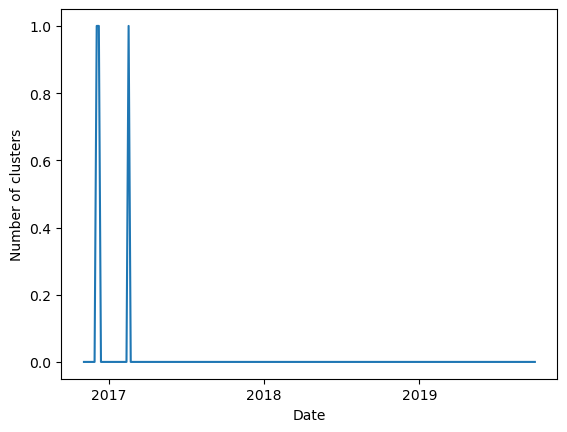

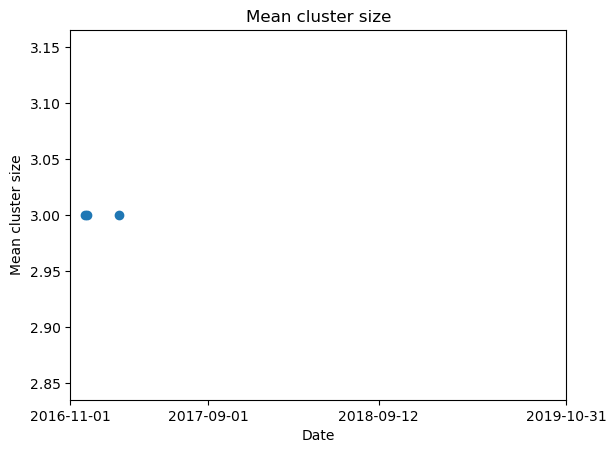

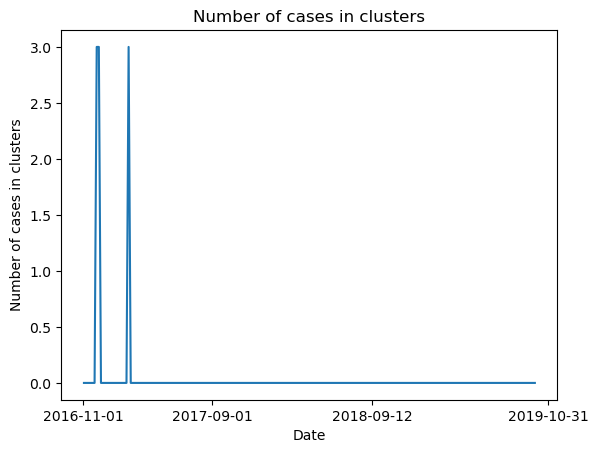

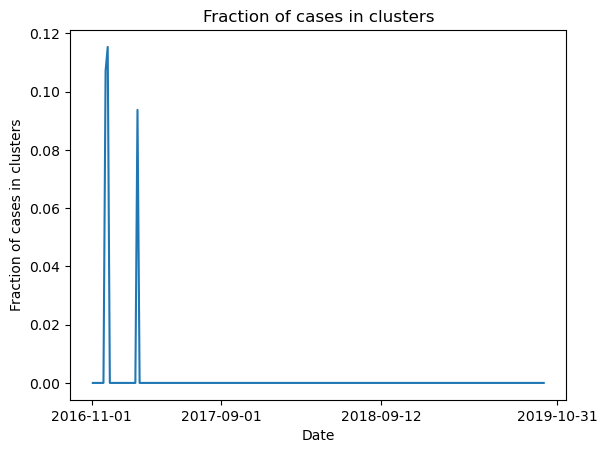

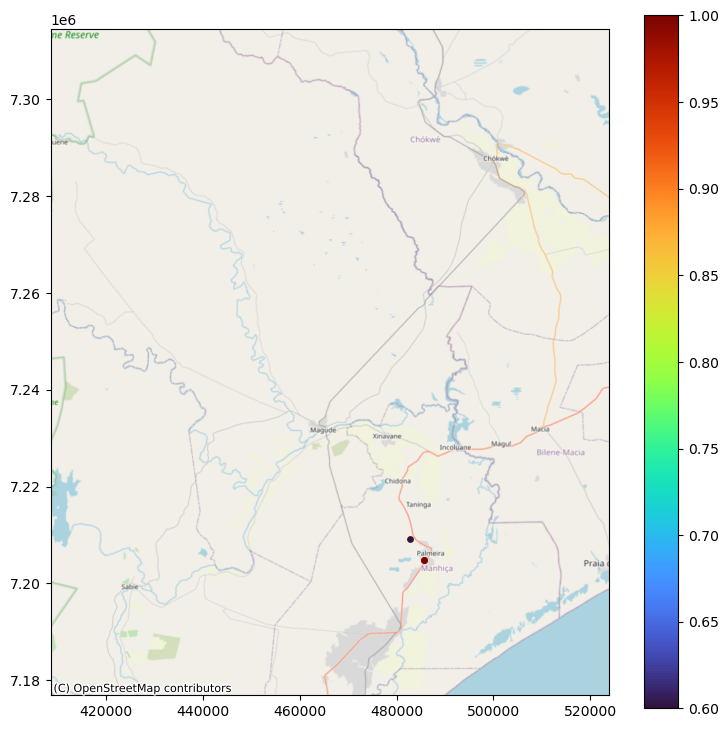

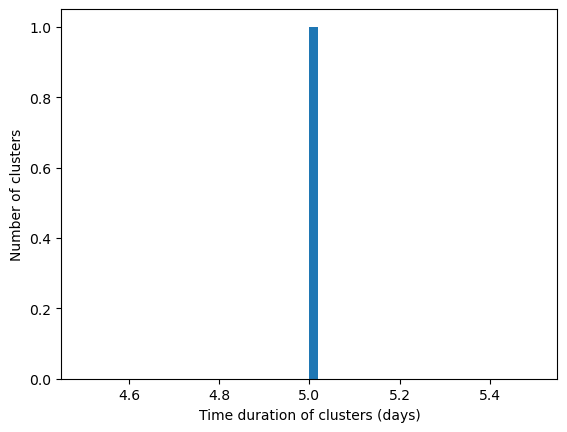

[0 5]
Maximum limelife: 5


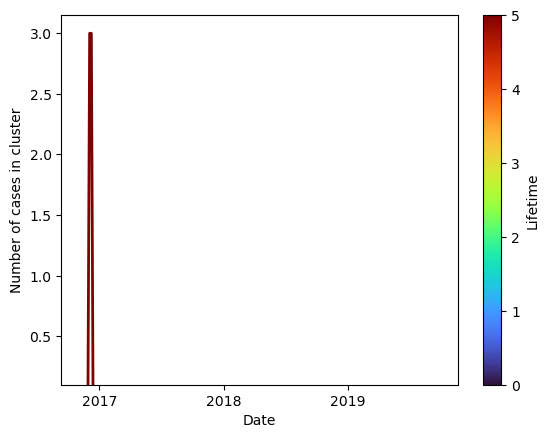

-------Running analysis for P1------


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

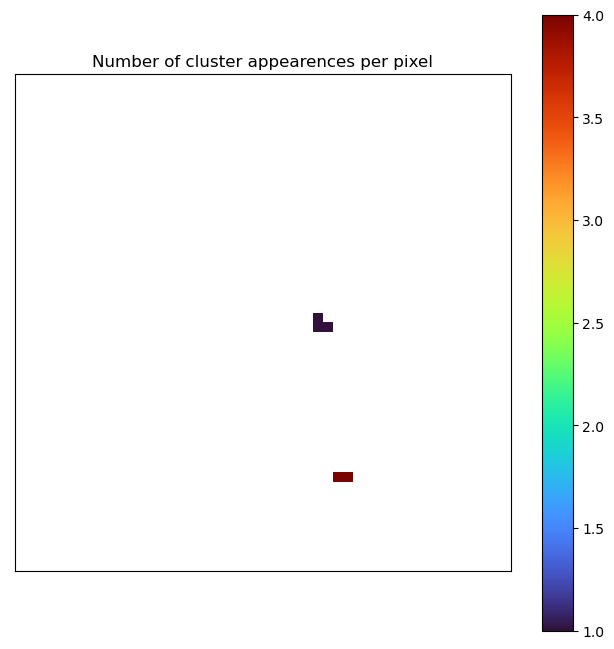

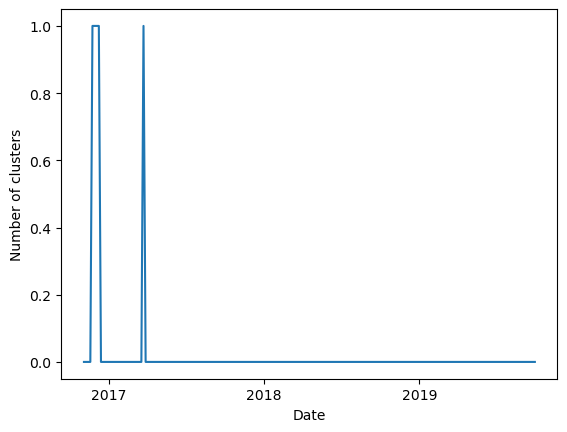

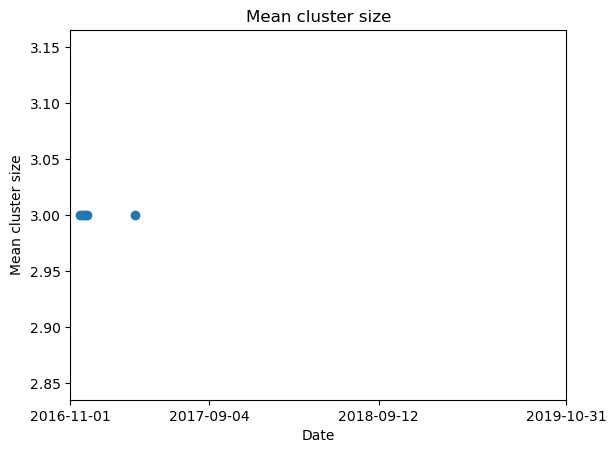

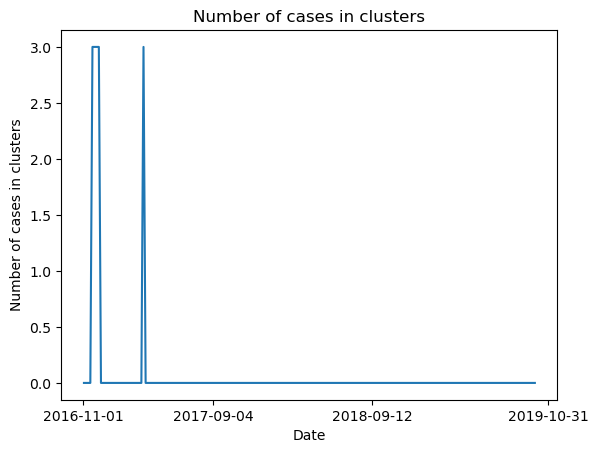

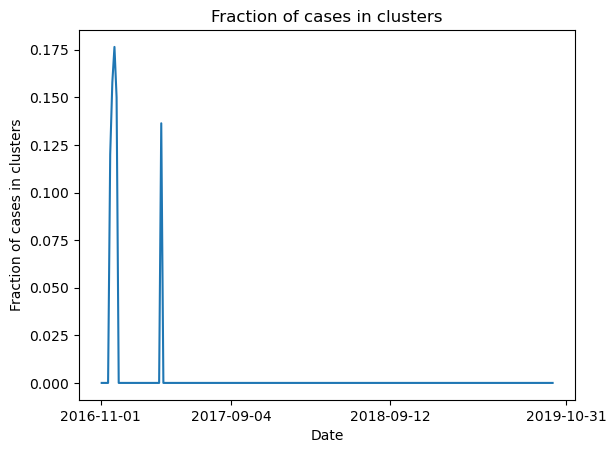

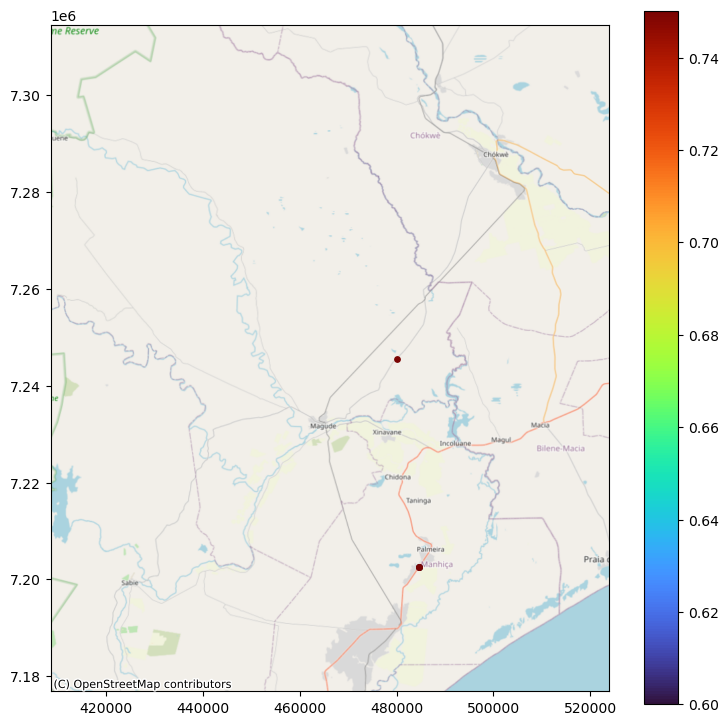

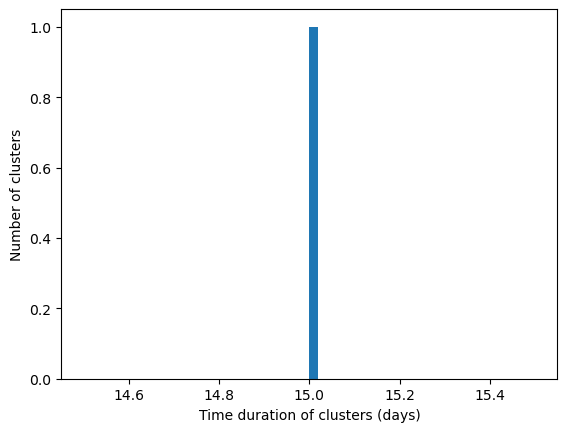

[ 0 15]
Maximum limelife: 15


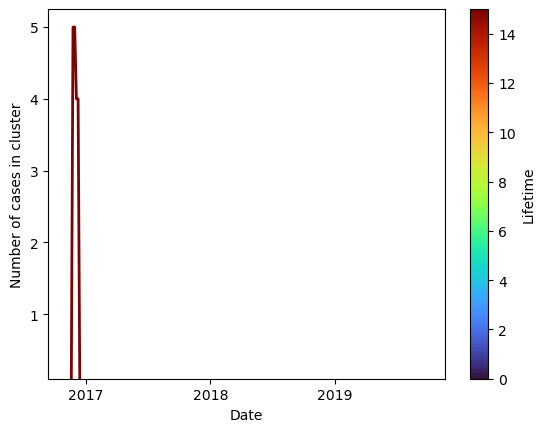

-------Running analysis for P39------


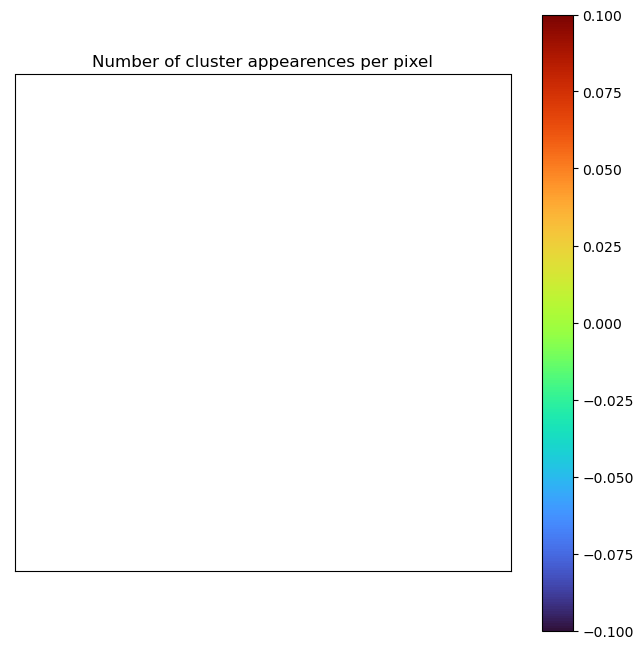

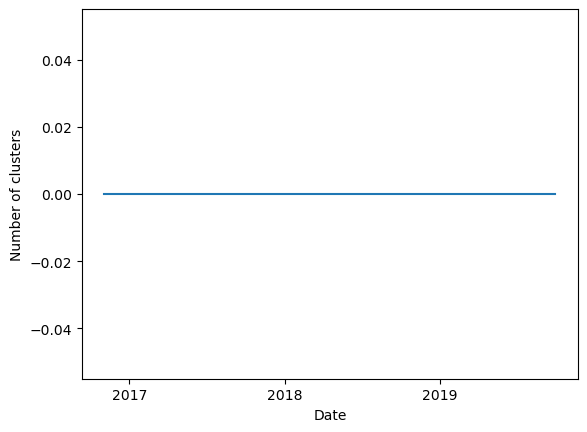

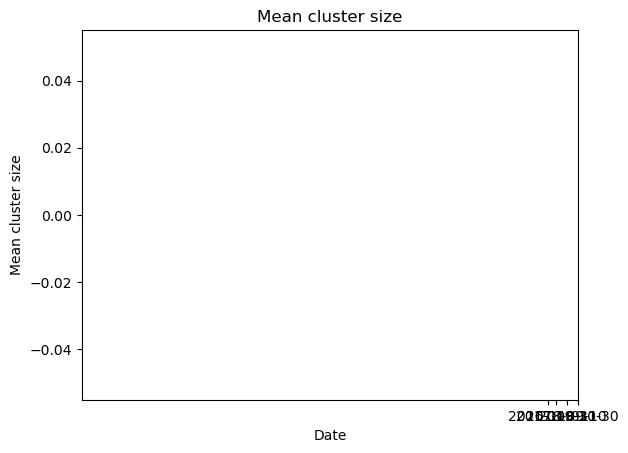

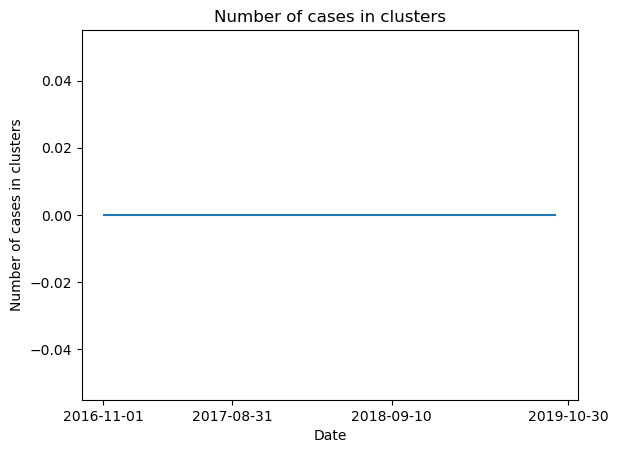

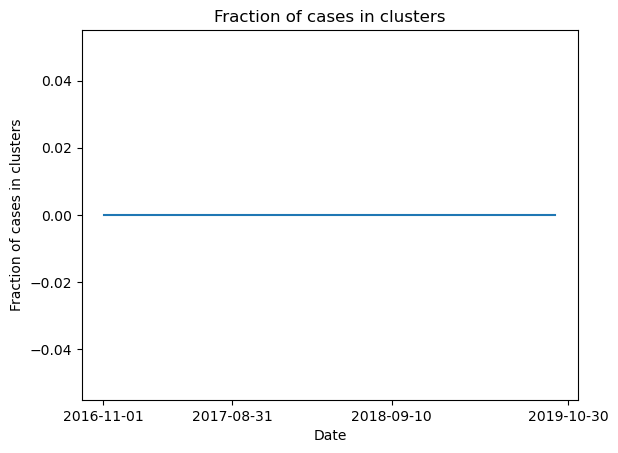

-------Running analysis for P8------


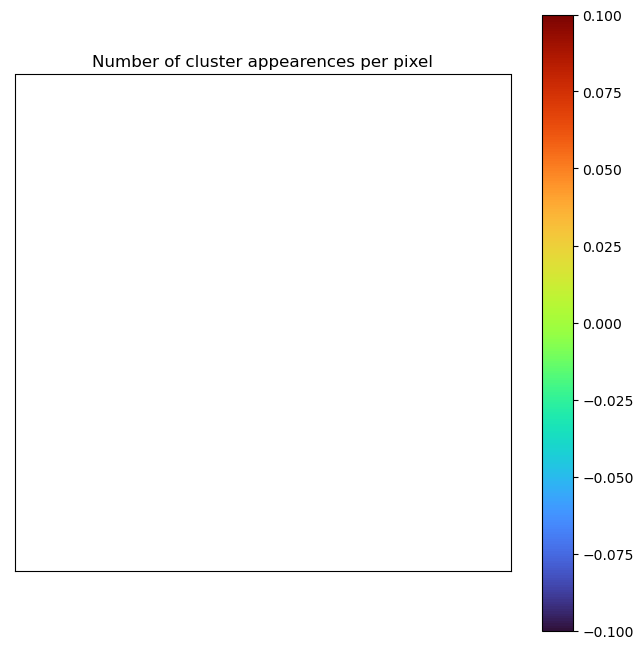

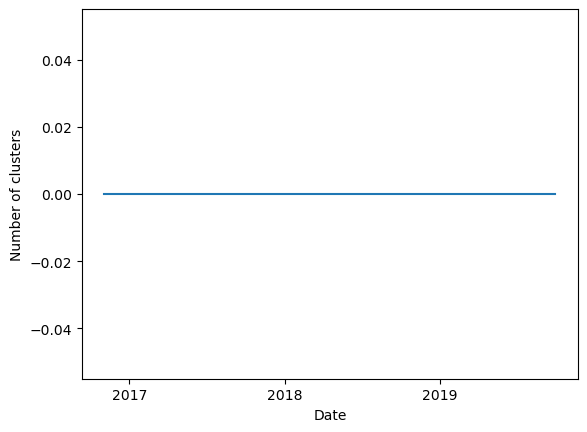

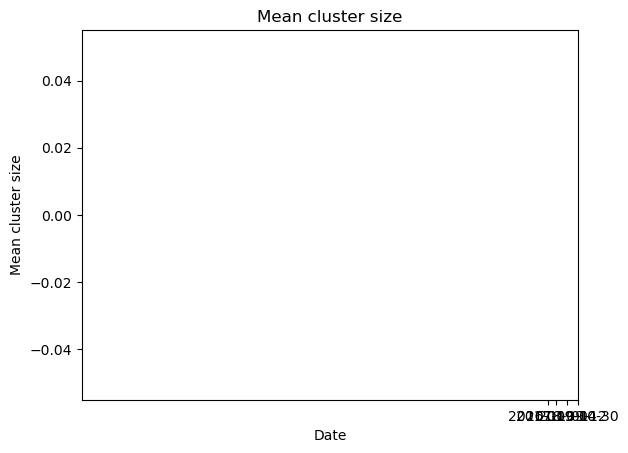

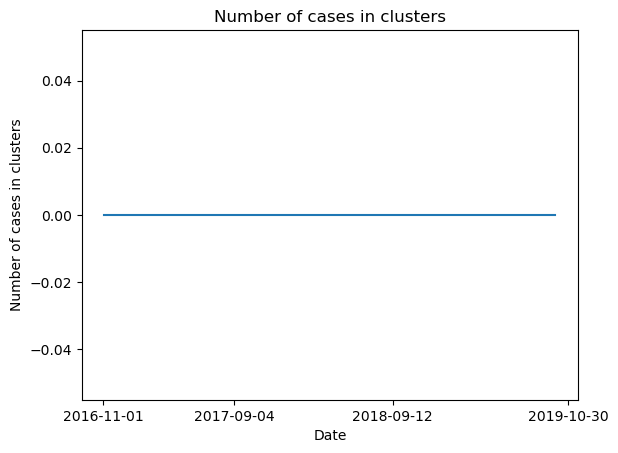

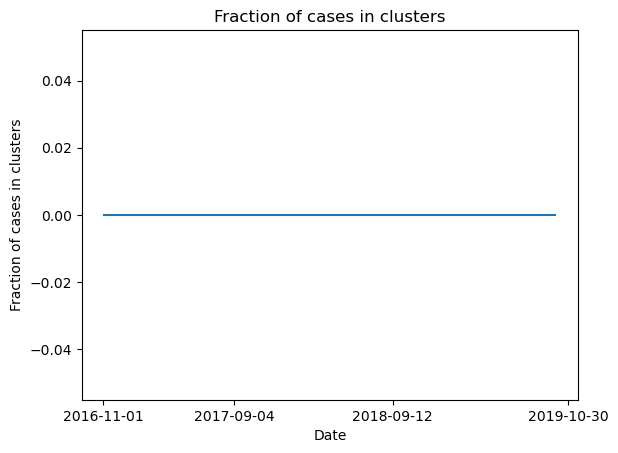

-------Running analysis for PD------


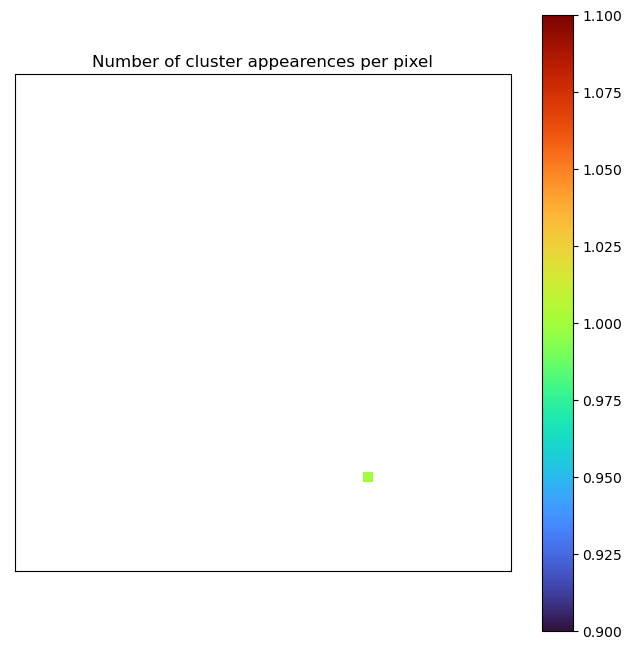

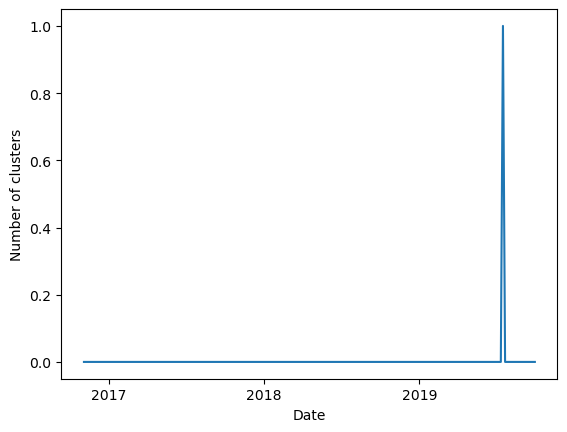

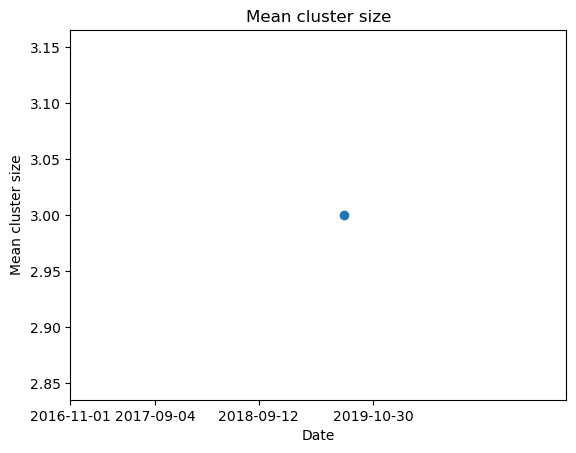

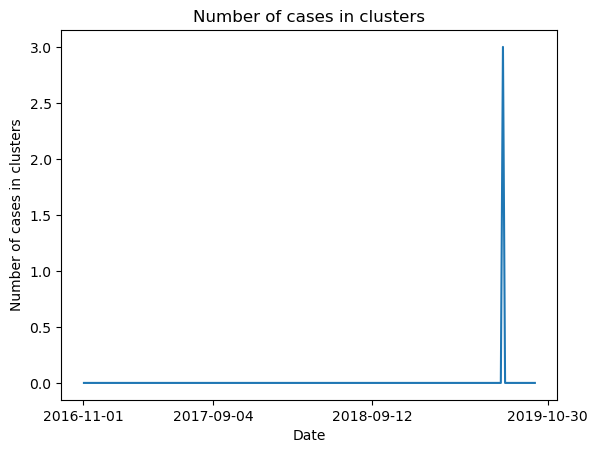

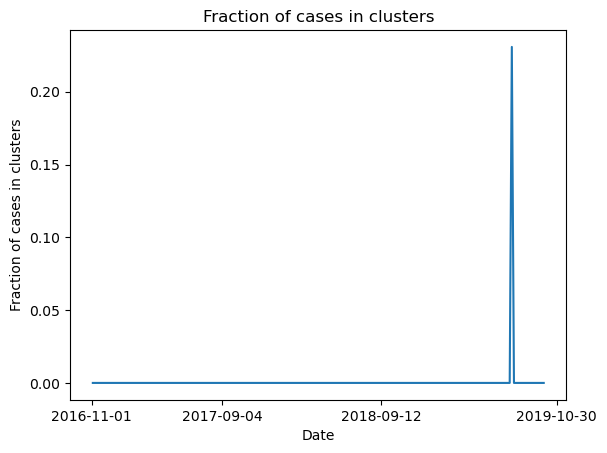

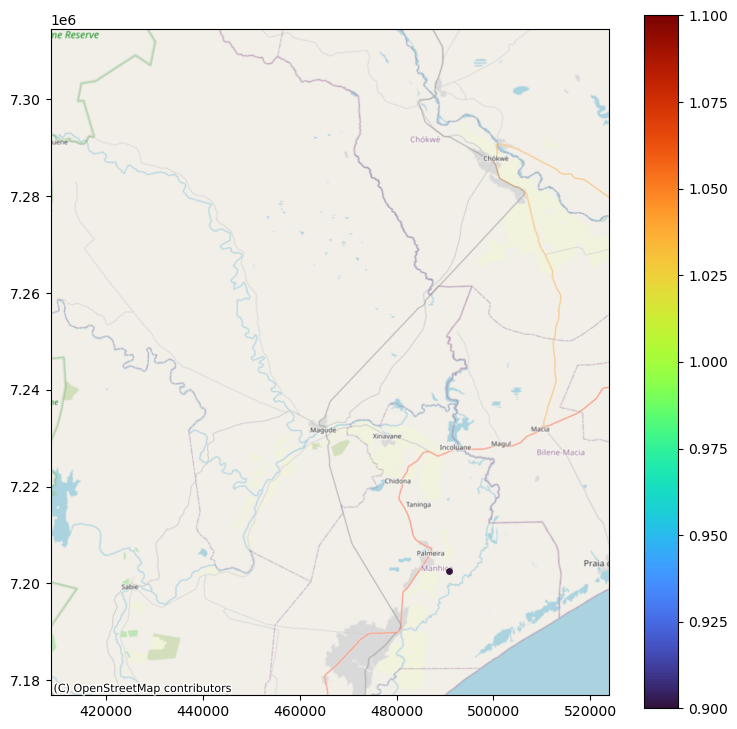

[0]
Maximum limelife: 0


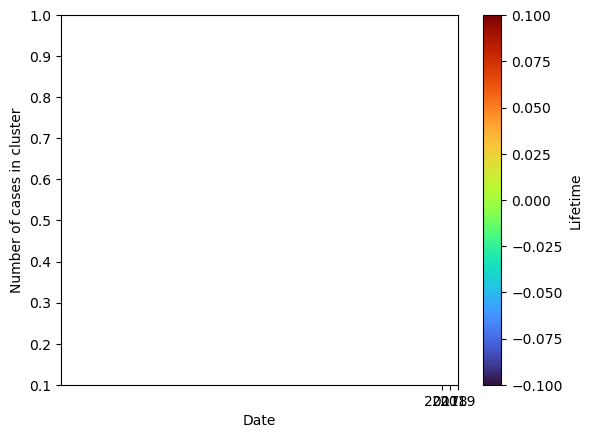

-------Running analysis for DBL34------


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

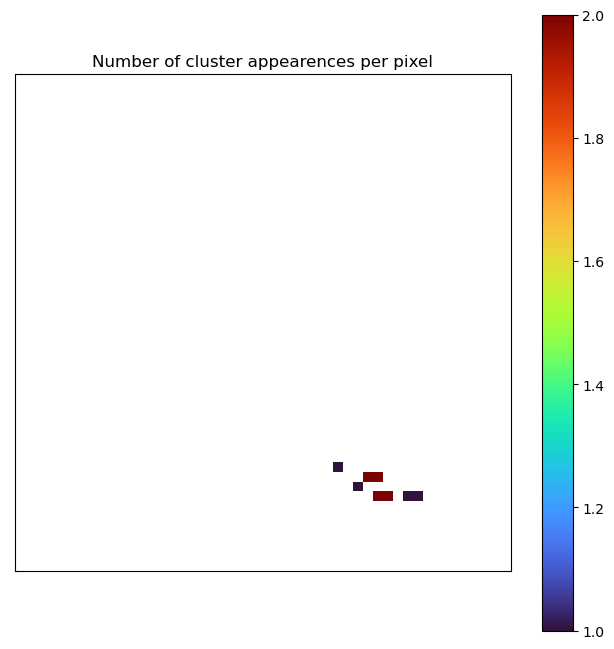

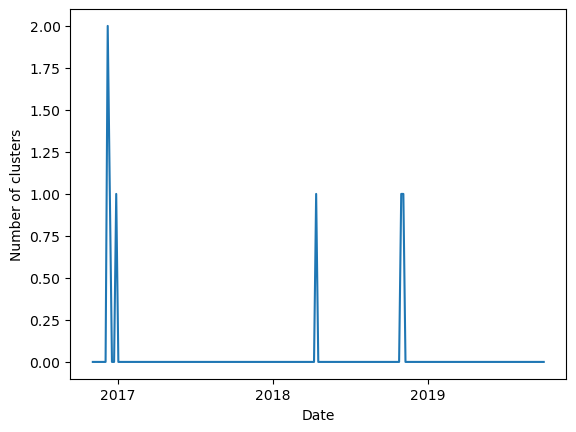

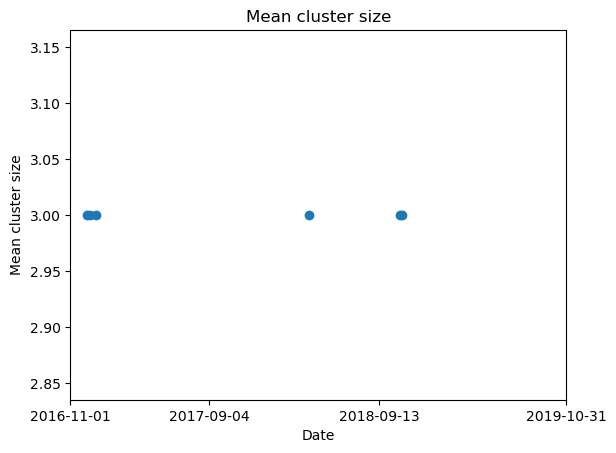

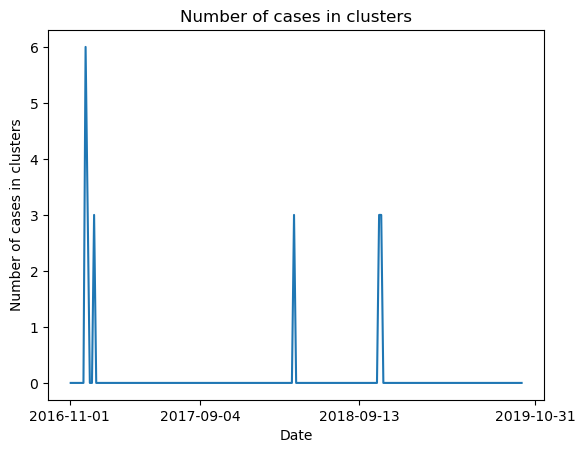

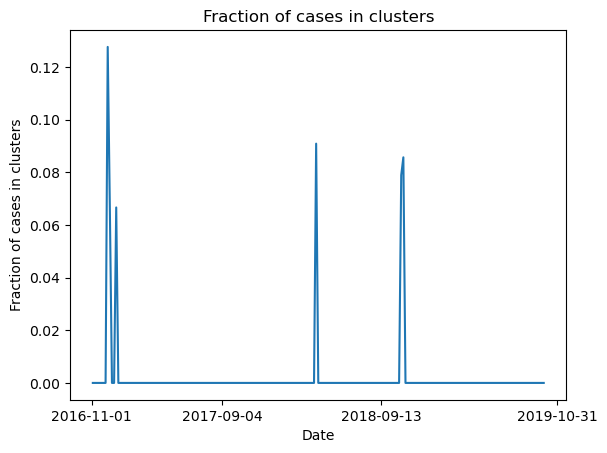

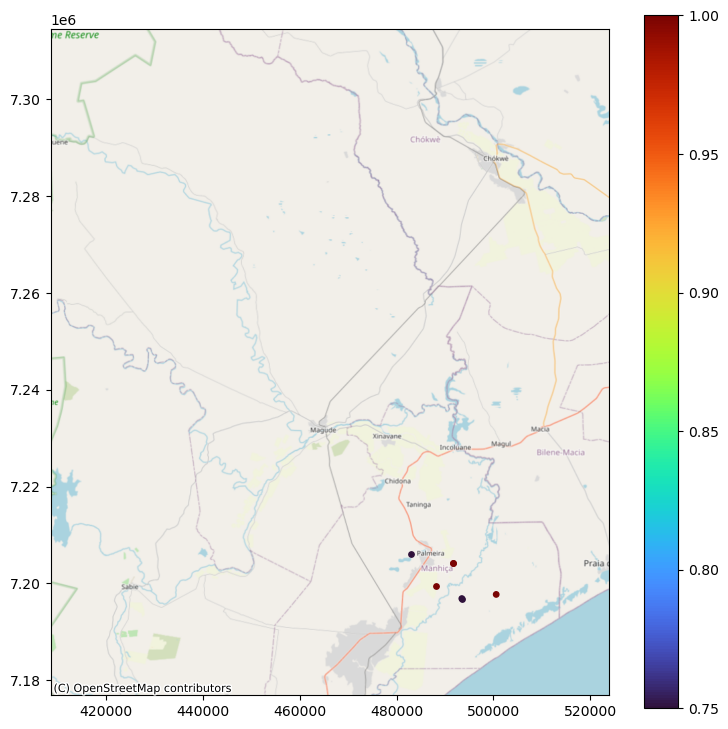

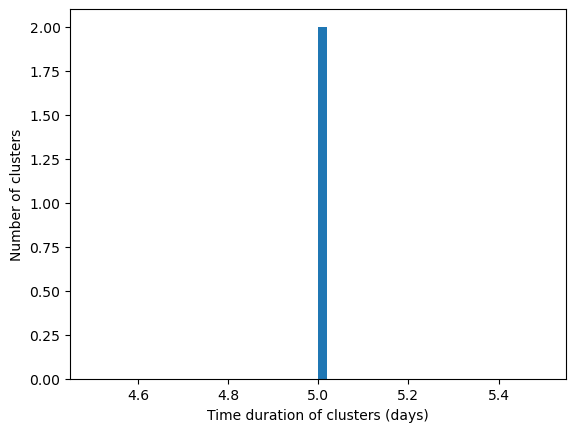

[0 5]
Maximum limelife: 5


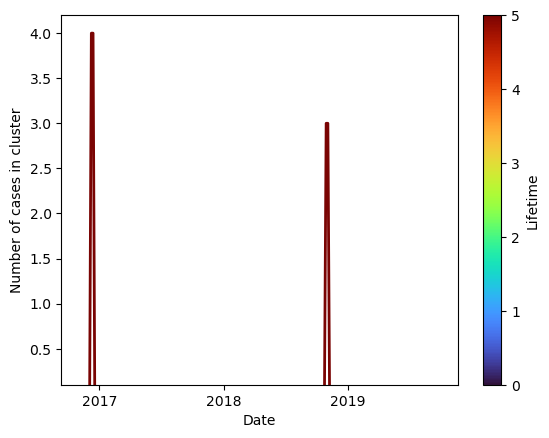

-------Running analysis for All peptides------


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

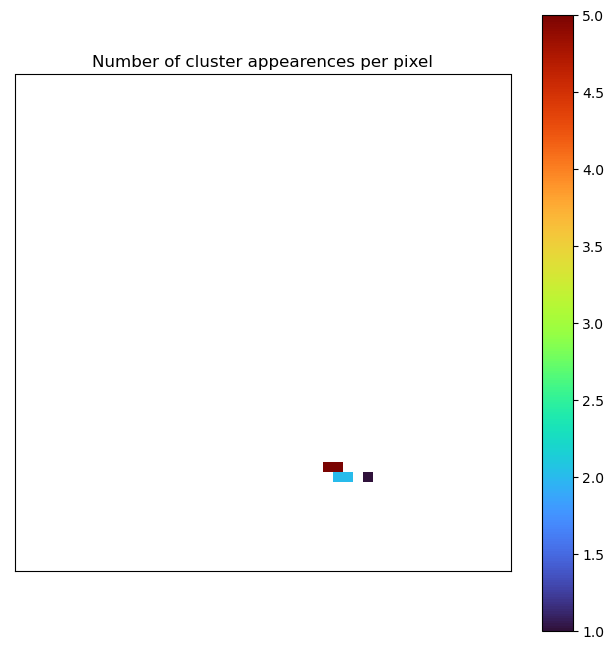

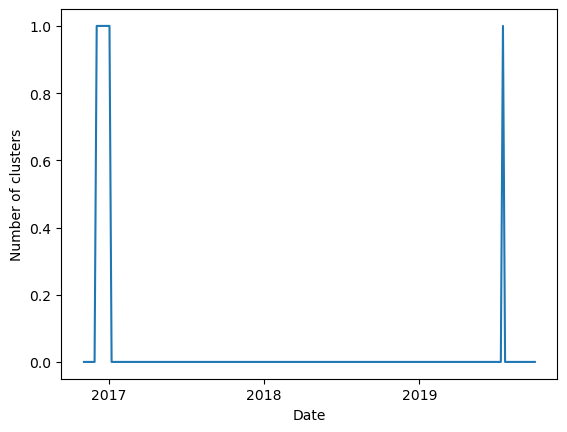

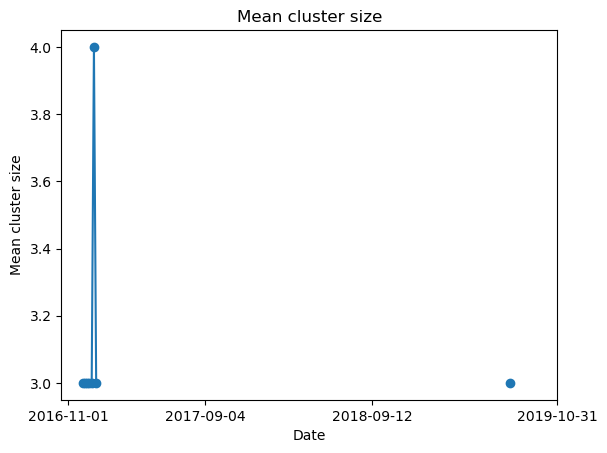

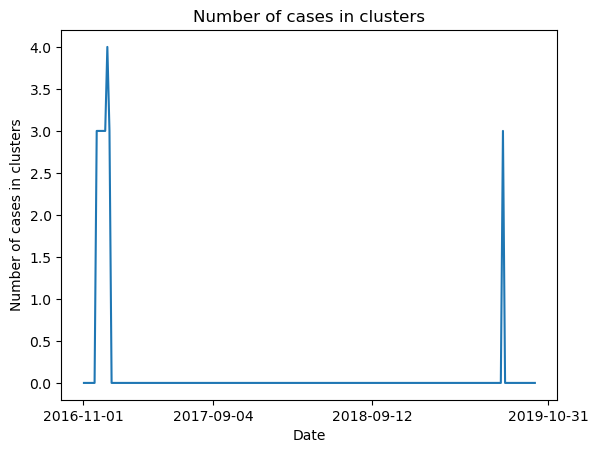

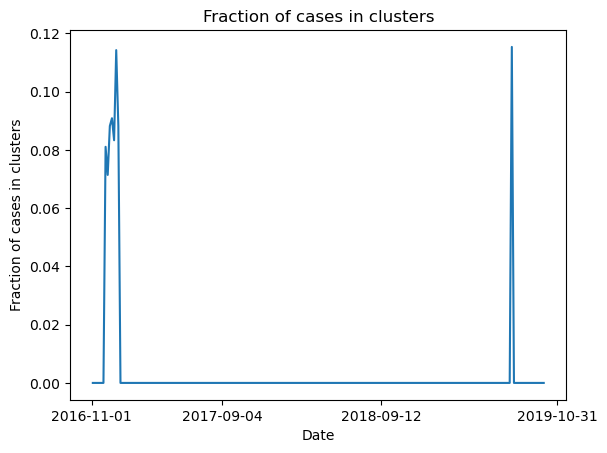

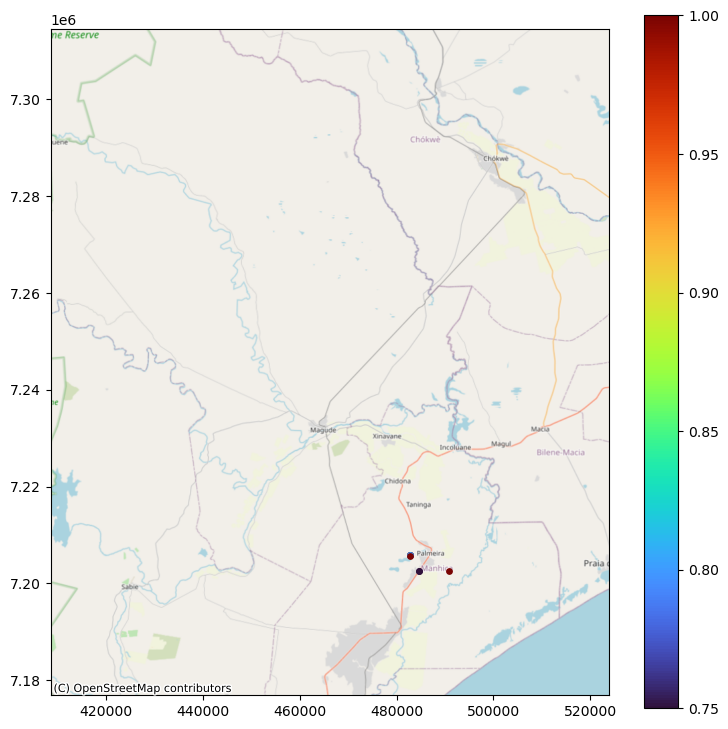

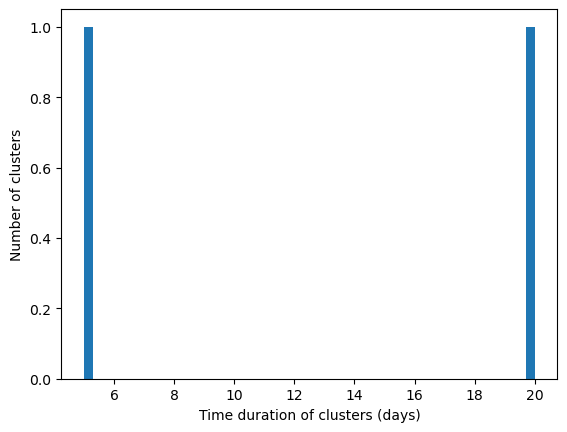

[ 0  5 20]
Maximum limelife: 20


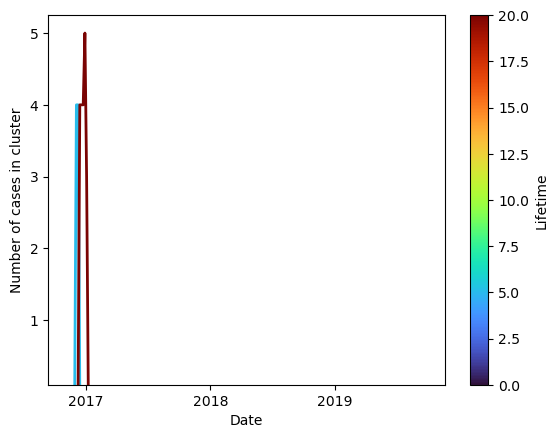

-------Running analysis for P1+P8------


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

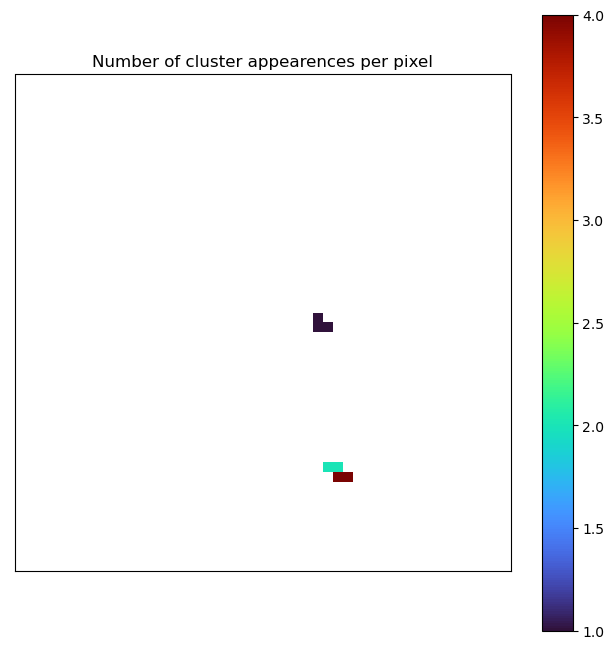

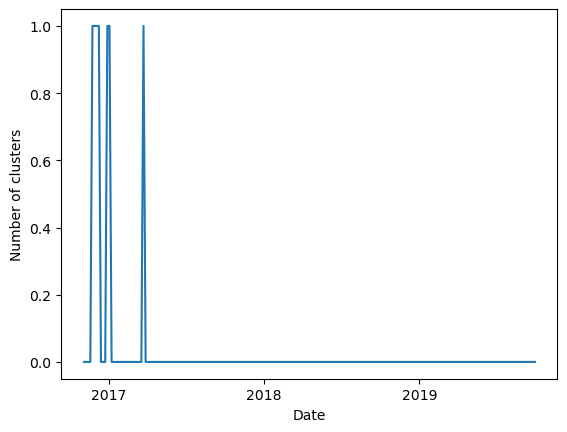

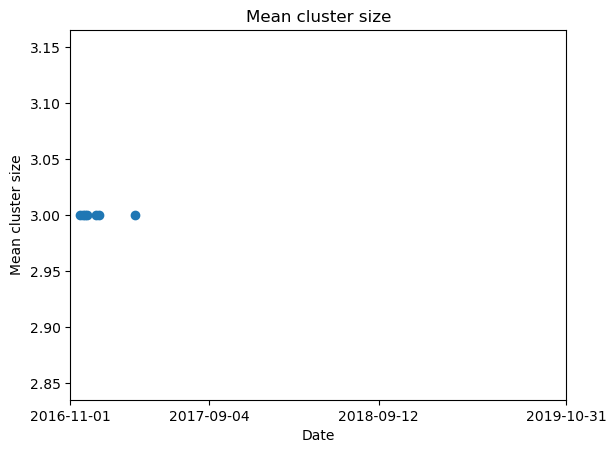

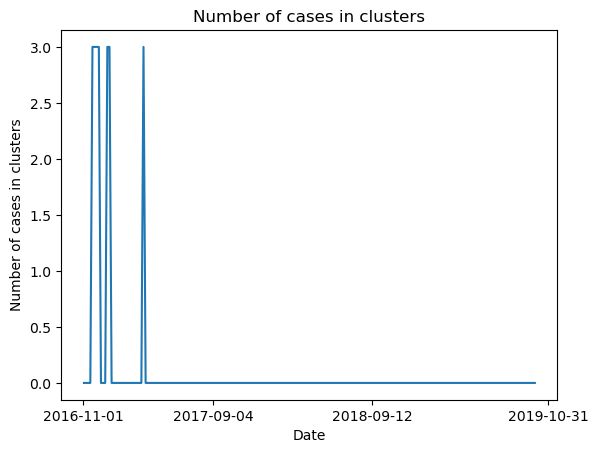

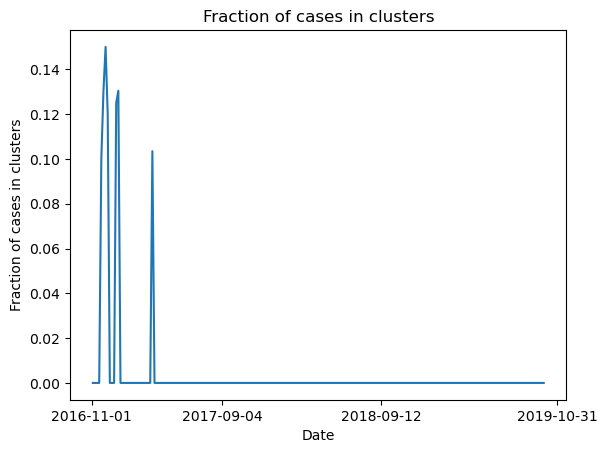

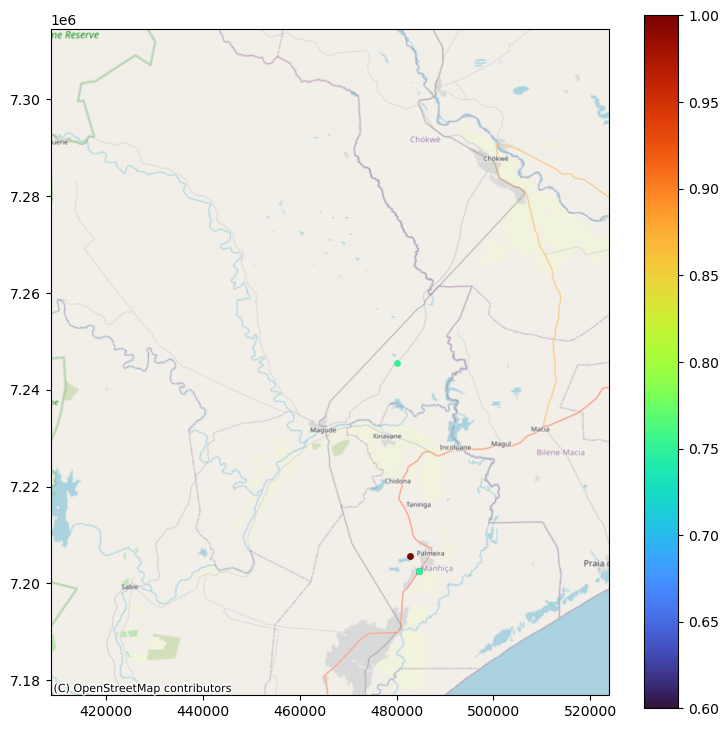

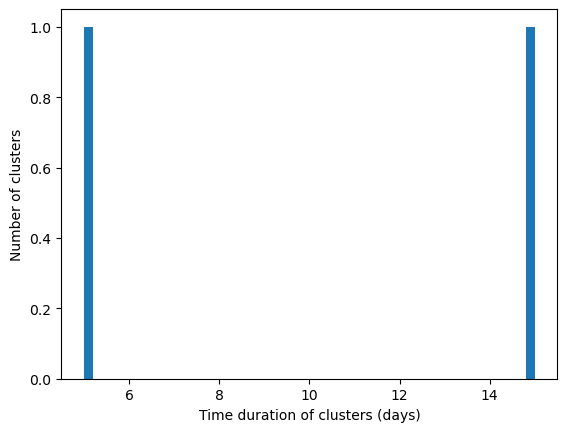

[ 0  5 15]
Maximum limelife: 15


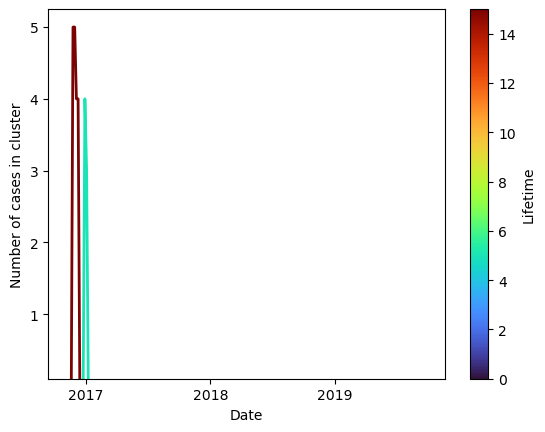

Time taken  172.50460815429688  seconds ( 2 minutes)


In [6]:
#time width in days
time_width = 30
#Temporal step of hotspot analysis
time_steps = 5
#linking distance of hotspot
scale = 1000
#minimum number of cases in hotspot
min_num = 3
#Linking time and distance for temporal ID
linking_time, linking_dist = 30, 2000
#Antigen
mean_date, fof_num, num_cases, mean_fof_size, \
fraction_cases, fof_cat = {}, {}, {}, {}, {}, {}

start = time()
for ant in antigens:
    print("-------Running analysis for " + ant + "------")
    antigen = 'FMM_' + ant
    
    mask = mipmon_selection['All prenatal']&(mipmon[antigen].notnull())
    testres = mipmon[antigen][mask]
    
    mean_date[ant], fof_num[ant], num_cases[ant], mean_fof_size[ant], fraction_cases[ant], \
    fof_cat[ant] = spatial_utils.get_temporal_hotspots(mipmon[mask], time_width, \
                                                       time_steps, scale, min_num, \
                                                       linking_time, linking_dist, \
                                                       label2plot = 'mean_pr', \
                                                       test_result = testres, show_maps = False, \
                                                       gif_delay = 20, method = 'fof', \
                                                       output_path = output_path, save = False, \
                                                       max_p_lifetimes = 0.05, name_end = '_' + antigen, \
                                                                           object_name = 'cluster')
end = time()
print('Time taken ', end-start,' seconds (', int((end-start)/60), 'minutes)')

In [7]:
def get_foci_years(epi_list, mean_dates):
    all_tempid = epifriends.get_label_list(epi_list, 'tempID')
    years = []
    for tid in all_tempid:
        times = find_timesteps_with_id(epi_list, tid)
        dates = pd.DataFrame({'visdate' : pd.Series(mean_dates[times])})
        year = spatial_utils.get_study_year(dates)
        years.append(int(round(np.mean(year),0)))
    year_counts = count_foci_per_year(np.array(years))
    return year_counts
def count_foci_per_year(years):
    year_counts = {}
    year_counts['Year 1'] = np.sum(years == 1)
    year_counts['Year 2'] = np.sum(years == 2)
    year_counts['Year 3'] = np.sum(years == 3)
    return year_counts

In [8]:
cluster_counts = pd.DataFrame(columns=['Year 1', 'Year 2', 'Year 3'], index=antigens)
for ant in antigens:
    year_counts = get_foci_years(fof_cat[ant], mean_date[ant])
    for y in ['Year 1', 'Year 2', 'Year 3']:
        cluster_counts.loc[ant,y] = get_foci_years(fof_cat[ant], mean_date[ant])[y]

In [9]:
#with mun_num = 3
cluster_counts

Year 1 Year 2 Year 3
MSP1              1      0      0
HSP40             0      0      0
Etramp            1      0      0
ACS5              2      0      0
EBA175            3      1      1
PfTramp           0      0      1
GEXP18            0      0      0
PfRH2             1      0      0
PfRH5             1      0      0
P1                1      0      0
P39               0      0      0
P8                0      0      0
PD                0      0      0
DBL34             1      1      0
All peptides      2      0      0
P1+P8             2      0      0

# Running temporal analysis for a particular antigen

/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/fof.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

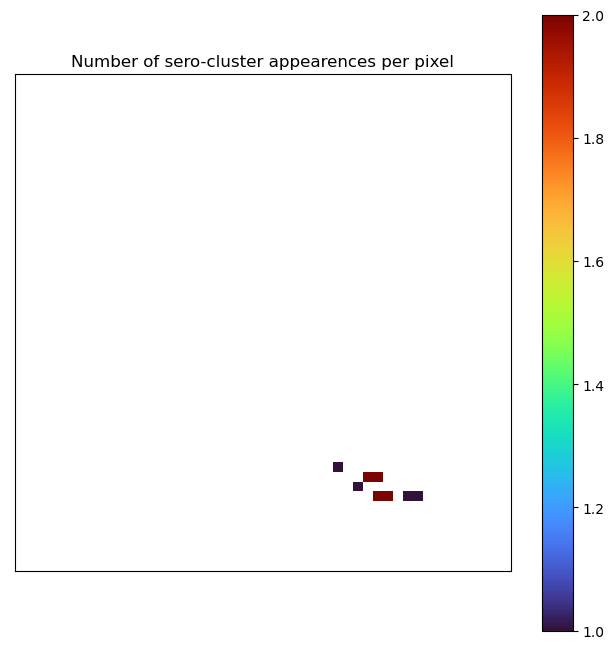

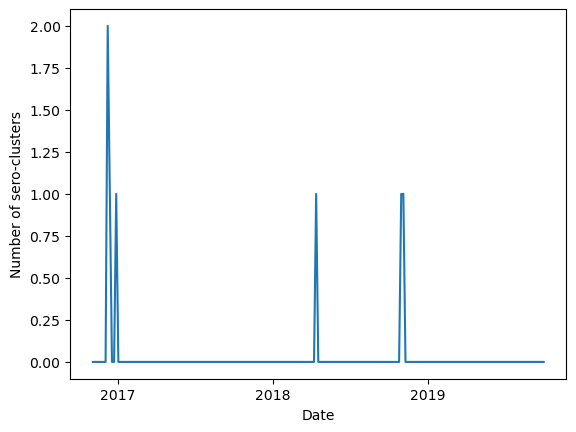

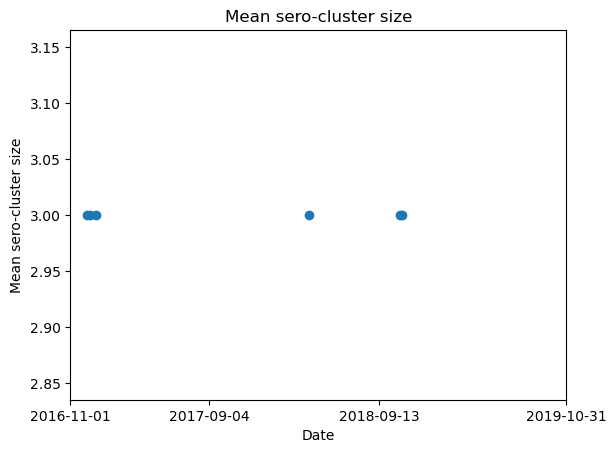

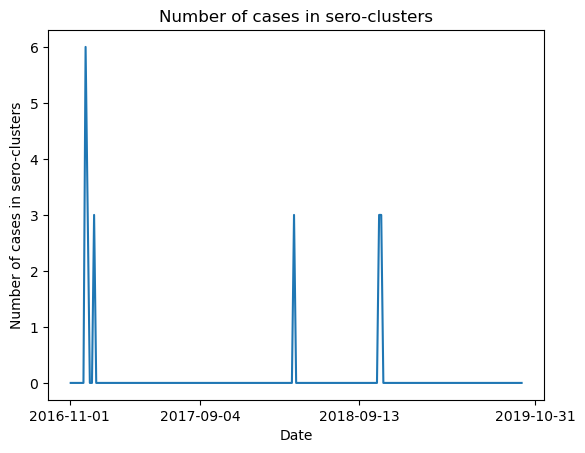

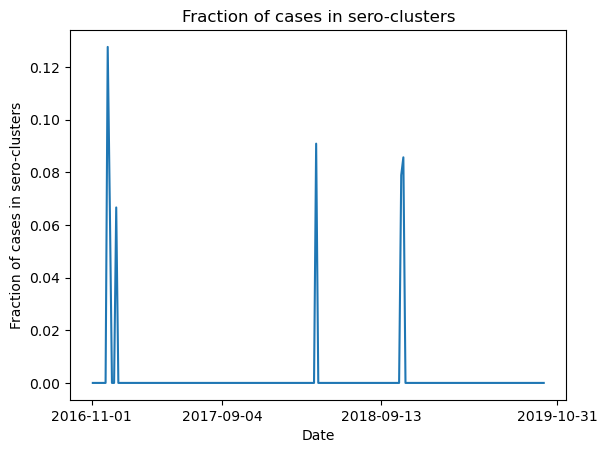

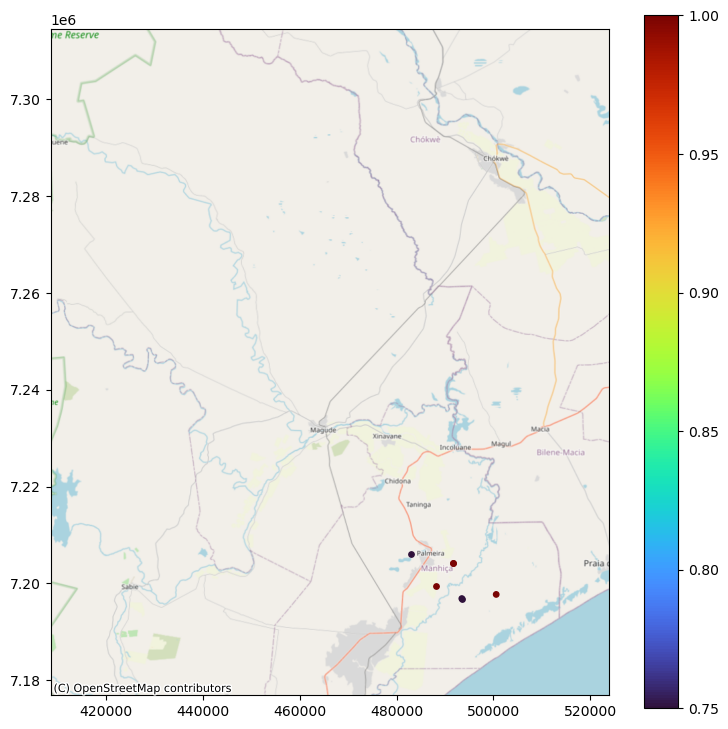

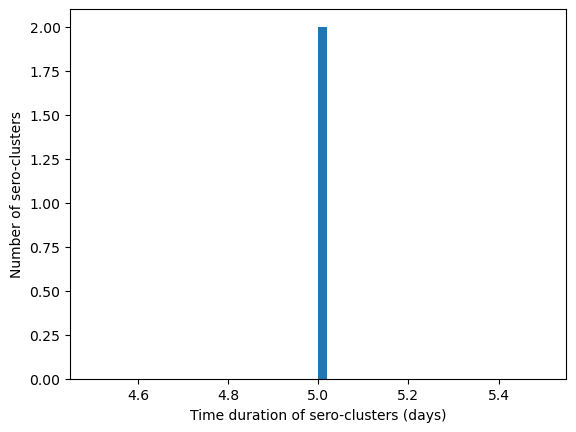

[0 5]
Maximum limelife: 5


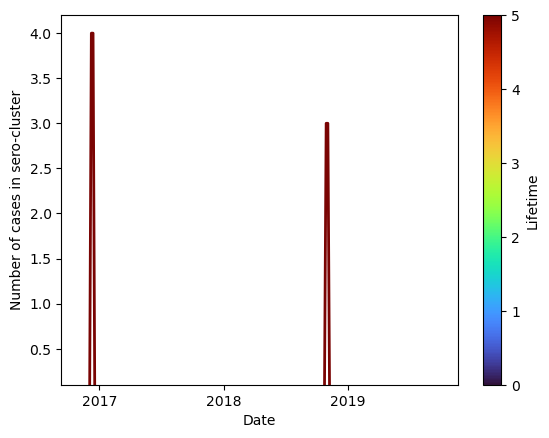

Time taken  10.200270652770996  seconds ( 0 minutes)


In [10]:
#time width in days
time_width = 30
#Temporal step of hotspot analysis
time_steps = 5
#linking distance of hotspot
scale = 1000
#minimum number of cases in hotspot
min_num = 3
#Linking time and distance for temporal ID
linking_time, linking_dist = 30, 2000
#Antigen
antigen = 'FMM_DBL34'

mask = mipmon_selection['All prenatal']&(mipmon[antigen].notnull())
testres = mipmon[antigen][mask]

start = time()
mean_date_dbl34, fof_num_dbl34, num_cases_in_dbl34, mean_fof_size_dbl34, fraction_cases_in_dbl34, \
fof_cat_dbl34 = spatial_utils.get_temporal_hotspots(mipmon[mask], time_width, \
                                                   time_steps, scale, min_num, \
                                                   linking_time, linking_dist, \
                                                   label2plot = 'mean_pr', \
                                                   test_result = testres, show_maps = False, \
                                                   gif_delay = 20, method = 'fof', \
                                                   output_path = output_path, save = False, \
                                                   max_p_lifetimes = 0.05, name_end = '_' + antigen, \
                                                                       object_name = 'sero-cluster')

end = time()
print('Time taken ', end-start,' seconds (', int((end-start)/60), 'minutes)')